**Курс** Специализация Data Science

**Дипломный проект.** Бриф учебного кейса 

«Модель прогнозирования стоимости жилья для агентства недвижимости»

**Цель**: разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

**Описание данных**:
- 'status' — статус продажи;
- 'private pool' и 'PrivatePool' — наличие собственного бассейна;
- 'propertyType' — тип объекта недвижимости;
- 'street' — адрес объекта;
- 'baths' — количество ванных комнат;
- 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
- 'fireplace' — наличие камина;
- 'city' — город;
- 'schools' — сведения о школах в районе;
- 'sqft' — площадь в футах;
- 'zipcode' — почтовый индекс;
- 'beds' — количество спален;
- 'state' — штат;
- 'stories' — количество этажей;
- 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);
- 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать)

2. Разведывательный анализ (EDA).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go
import scipy as sp
import scipy.optimize as spo
from scipy import stats
import statsmodels.api as sm
from itertools import chain
from scipy.stats import shapiro
from scipy.stats import anderson
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import category_encoders as ce

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
# зафиусируем RANDOM_SEED
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов
!pip freeze > requirements.txt

In [233]:
df = pd.read_csv('data/cleaned_data.csv')
display(df.head())
df.info()

,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool_final,beds_final,school_rating _mean,school_dist_min,Year built,Heating_final,Cooling_encoded,Parking_encoded
0,Active,single family,240 Heather Ln,4.0,Southern Pines,2900,28387,NC,418000,False,4.0,5.2,2.70,2019,True,False,False
1,For Sale,single family,12911 E Heroy Ave,3.0,Spokane Valley,1947,99216,WA,310000,False,3.0,4.0,1.01,2019,False,False,False
2,For Sale,single family,2005 Westridge Rd,2.0,Los Angeles,3000,90049,CA,2895000,True,3.0,6.7,1.19,1961,True,True,True
3,For Sale,single family,4311 Livingston Ave,8.0,Dallas,6457,75205,TX,2395000,False,5.0,5.6,0.10,2006,True,True,True
4,For Sale,land,1524 Kiscoe St,0.0,Palm Bay,0,32908,FL,5000,False,0.0,4.7,3.03,unknown,False,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374249 entries, 0 to 374248
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               374249 non-null  object 
 1   propertyType         374249 non-null  object 
 2   street               374249 non-null  object 
 3   baths                374249 non-null  float64
 4   city                 374249 non-null  object 
 5   sqft                 374249 non-null  int64  
 6   zipcode              374249 non-null  int64  
 7   state                374249 non-null  object 
 8   target               374249 non-null  int64  
 9   private_pool_final   374249 non-null  bool   
 10  beds_final           374249 non-null  float64
 11  school_rating _mean  374249 non-null  float64
 12  school_dist_min      374249 non-null  float64
 13  Year built           374249 non-null  object 
 14  Heating_final        374249 non-null  bool   
 15  Cooling_encoded  

Как вы видим, признак zipcode а нашем датасете является числовым, хотя должен быть категориальным. Исправим его.

In [234]:
df['zipcode'] = df['zipcode'].astype(str)

Создадим список числовых признаков.

In [235]:
num_features = ['baths', 'sqft', 'beds_final', 'target', 'school_rating _mean', 'school_dist_min']

Построим диаграмму рассеяния, и для наглядности, тут же коробчатую диаграмму.

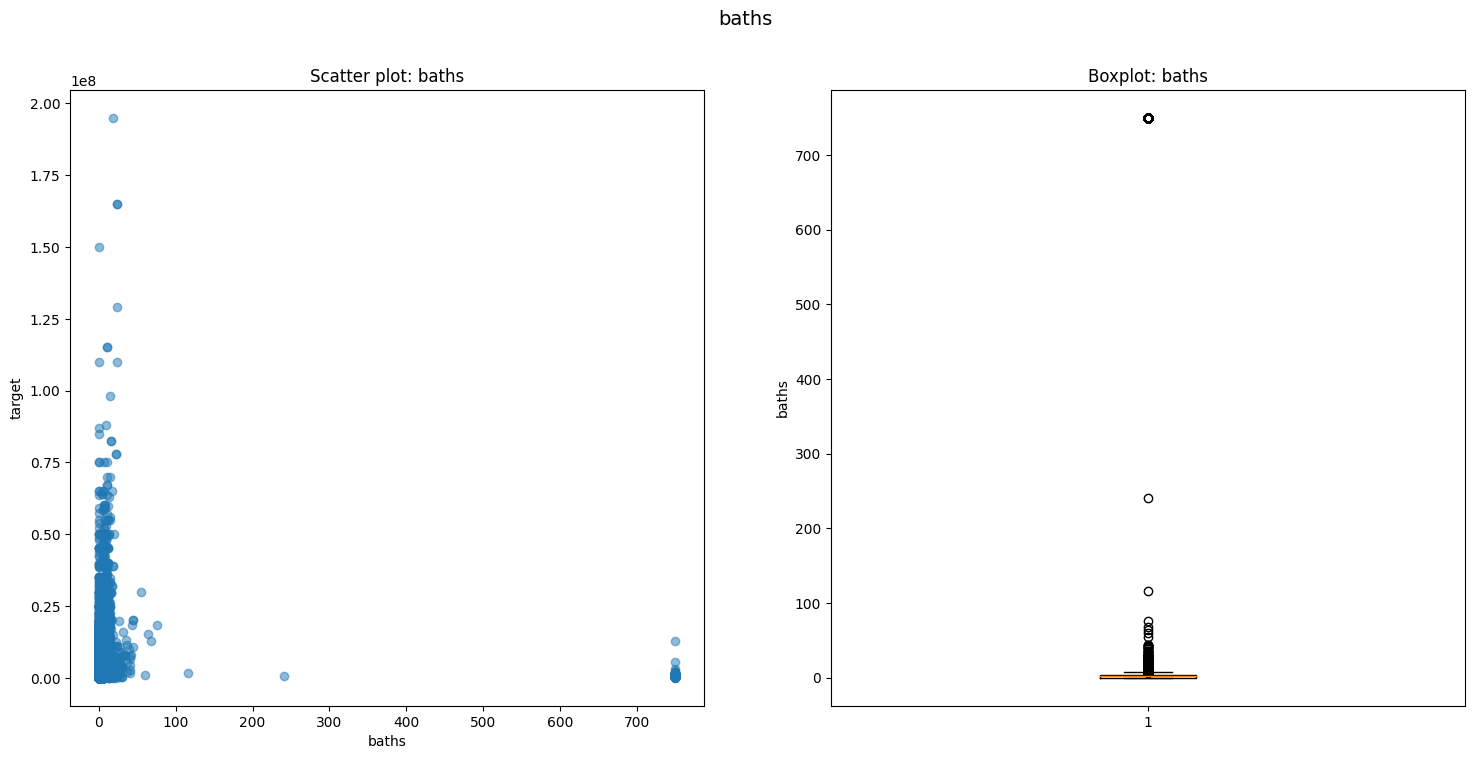

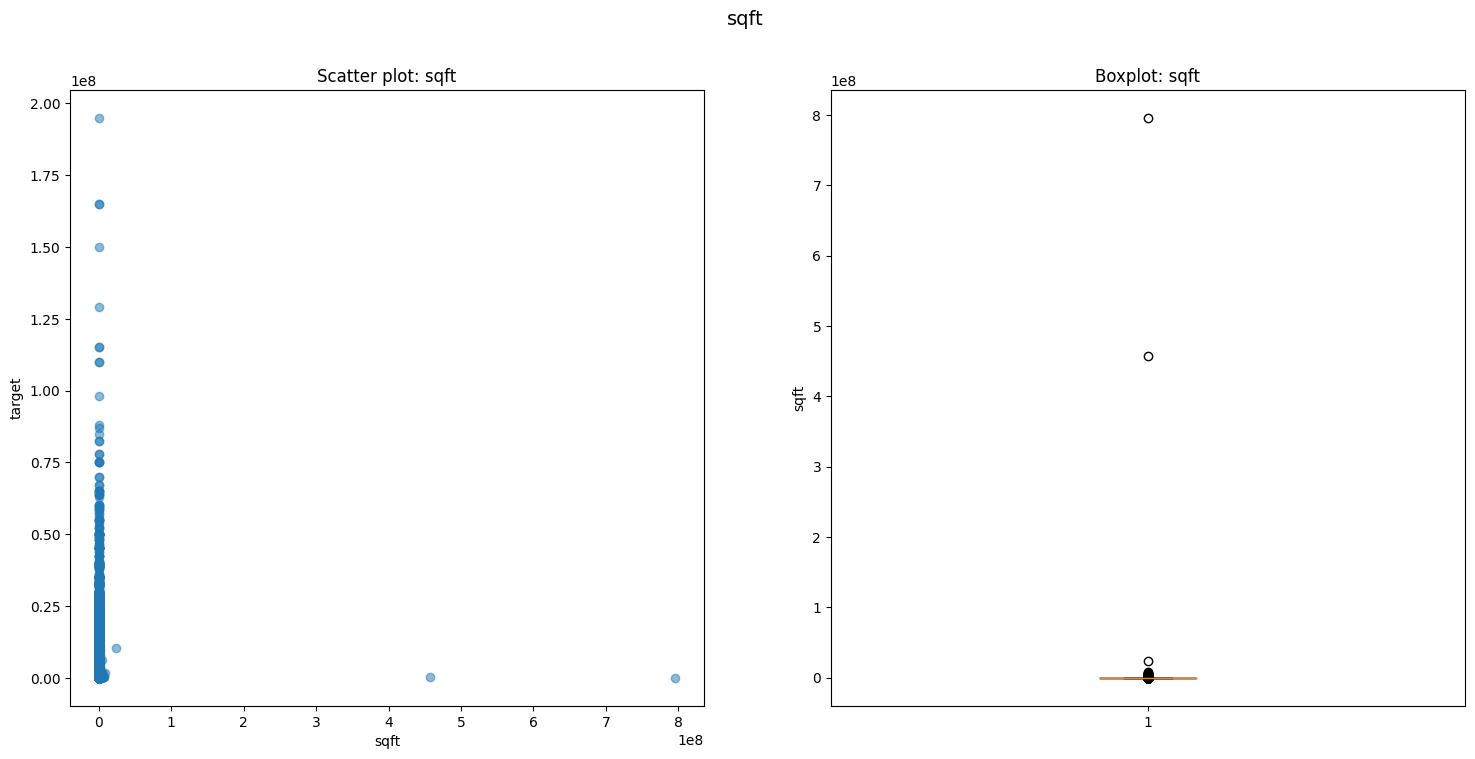

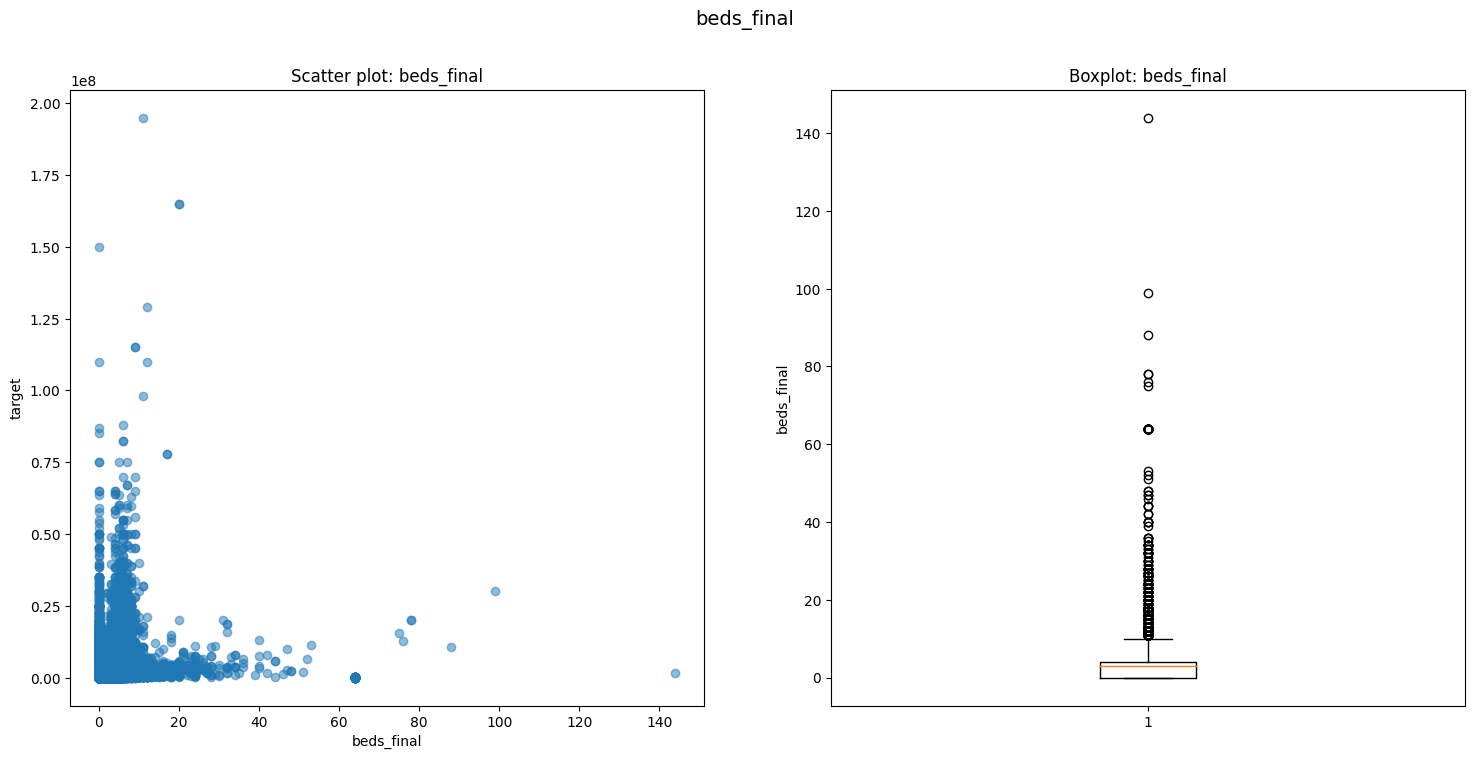

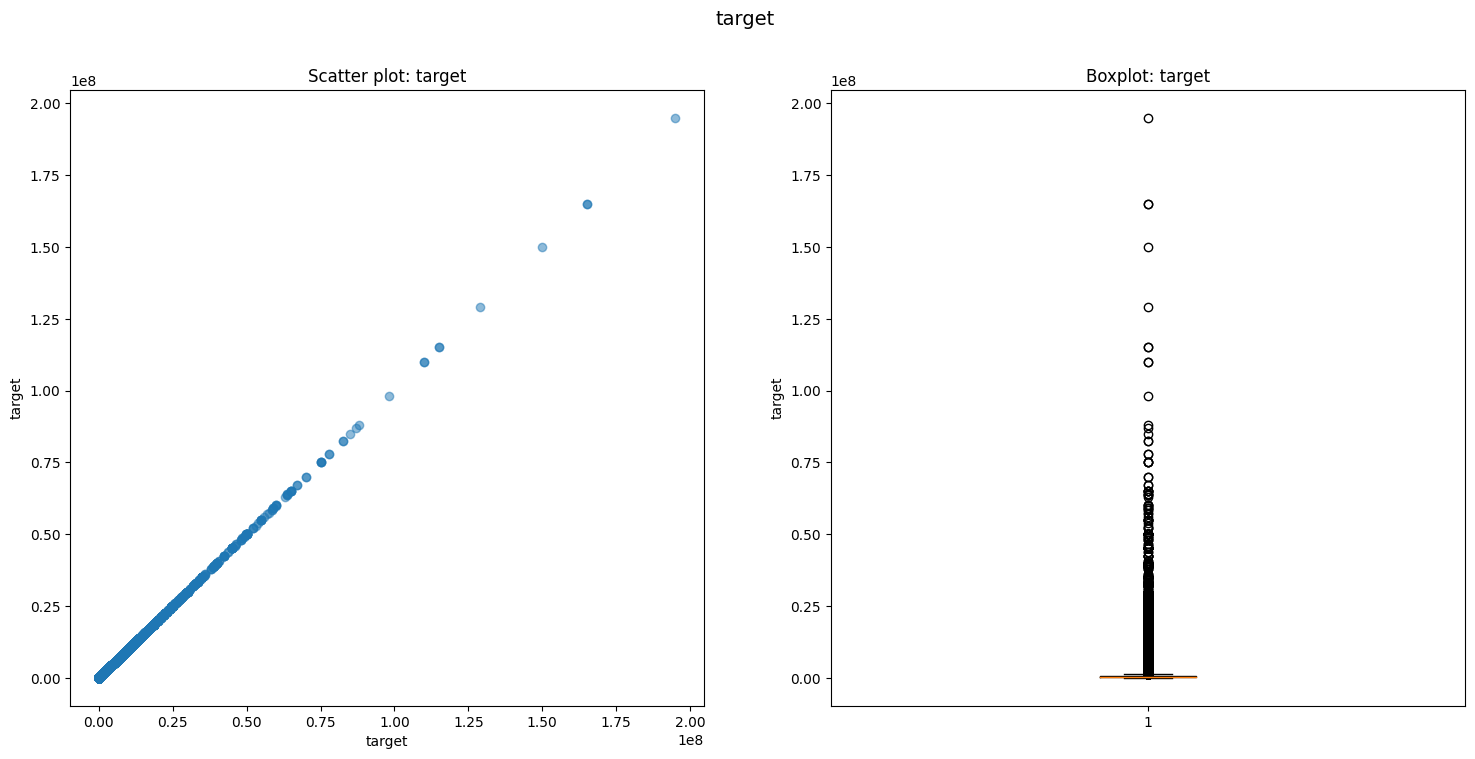

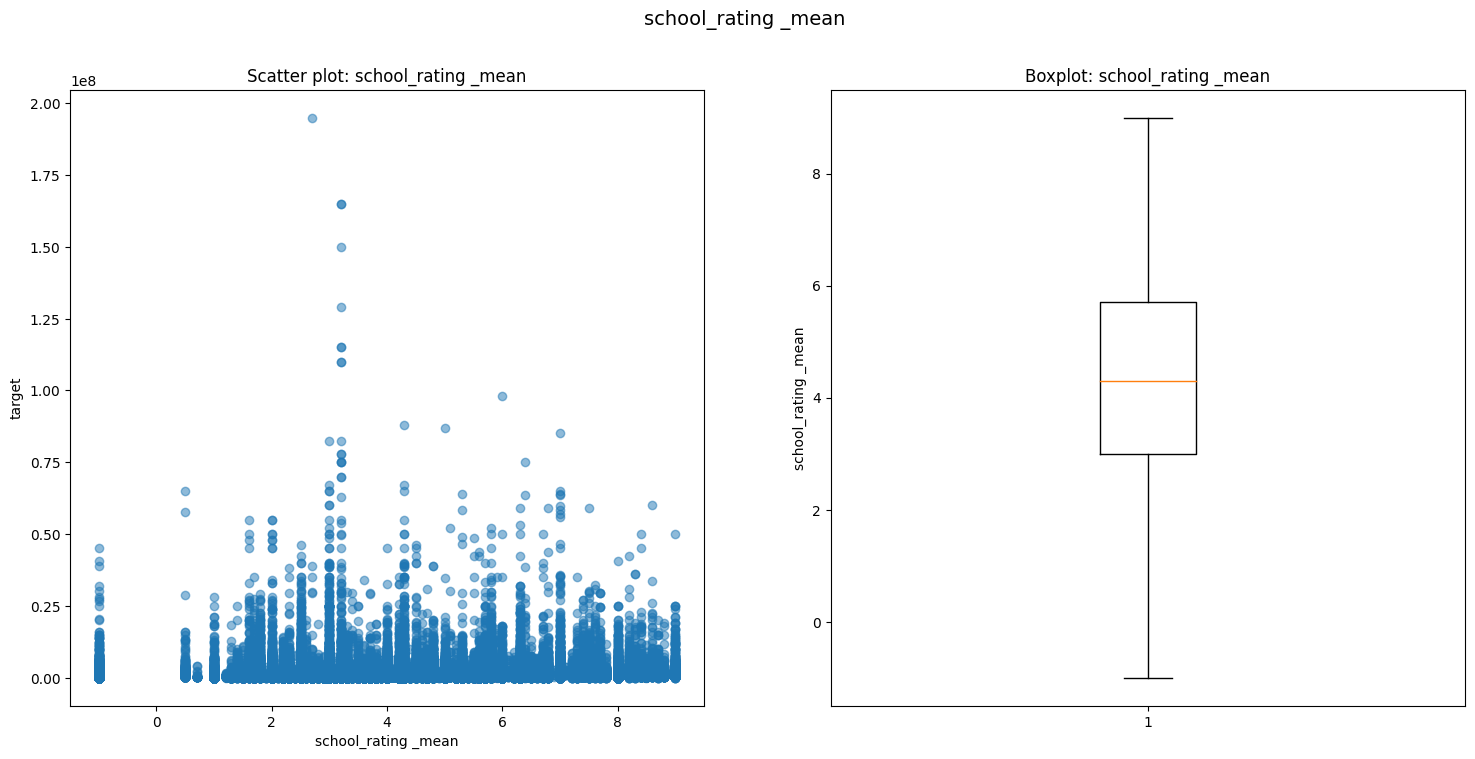

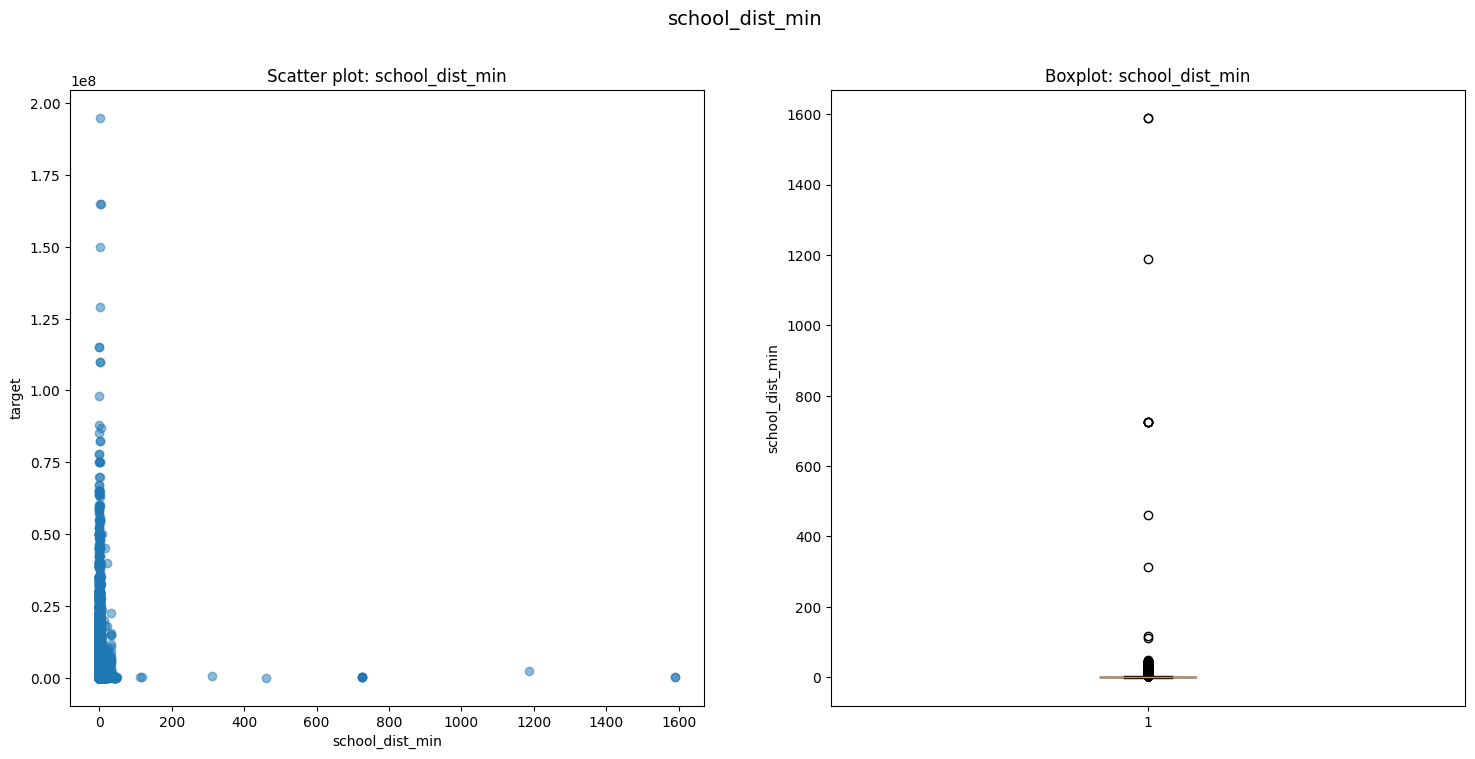

In [169]:
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle(f'{feature}', fontsize=14)

    # диаграмма рассеяния
    ax1.scatter(df[feature], df['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # коробчатая диаграмма
    ax2.boxplot(df[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()


Выводы:

- Исходя из обоих графиков, отчетливо выбиваются значения ванных комнат примерно 110, 250 и 750, при том что цена явно слишком низкая для такого количества. Что явно является выбросами.
- Также и с площадью, выбиваются большие значения выше 455 с низкой ценой, цена выше 195000000 и площадь равная нулю, что является выбросами.  
- По распределению спален видим выбивающиеся значения более 20, где цена слишком низкая, а также цены более 150000000 - явные выбросы.
- Рейтинг на графиках распределен нормально.
- Расстояние до школы - выбиваются значения выше 200.

In [236]:
# посмотрим на выбросы 
condition = (df['baths'].isin([110,250,750]))
filtered_df = df[condition]
# выведем отфильтрованные строки
display(filtered_df.head(5))
# посчистаем среднее значение 'sqft'
average_sqft = filtered_df['sqft'].mean()
# выведем среднее значение 'sqft'
print("Среднее значение sqft: ", average_sqft)

,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool_final,beds_final,school_rating _mean,school_dist_min,Year built,Heating_final,Cooling_encoded,Parking_encoded
1093,Active,multi family,3624 Douglas Ave,750.0,Dallas,1758,75219,TX,499000,False,0.0,2.6,0.9,1993,False,True,False
1998,Active,other,920 I St NW #411,750.0,Washington,1367,20001,DC,1499000,False,0.0,6.8,0.3,2013,False,False,False
3559,Active,other,601 W 11th Ave #409,750.0,DENVER,873,80204,CO,348900,False,0.0,4.0,0.2,1981,True,True,False
7489,Active,other,1260 Xavier St,750.0,DENVER,1864,80204,CO,560000,False,0.0,2.0,0.5,1936,True,False,False
7616,Active,condo,3314 Douglas Ave Unit 202D,750.0,Dallas,1336,75219,TX,285000,False,0.0,2.0,1.0,1984,False,True,False


Среднее значение sqft:  1681.7805907172997


Удалим эти выбросы.

In [237]:
df.drop(df[condition].index, inplace=True)

In [238]:
condition2 = ((df['beds_final'] > 20) | (df['target'] > 150000000))
filtered2_df = df[condition2]
# выведем отфильтрованные строки
display(filtered2_df.head(10))

,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool_final,beds_final,school_rating _mean,school_dist_min,Year built,Heating_final,Cooling_encoded,Parking_encoded
3321,Active,multi family,1684 Murchison St,18.0,Los Angeles,12052,90033,CA,3600000,False,32.0,5.5,0.20,1965,True,True,False
6222,For Sale,multi family,2509 NW 9th Ave,16.0,Wilton Manors,13925,33311,FL,2640000,False,26.0,5.3,0.72,1968,True,True,True
6254,For Sale,land,5906 Elk Hound Trl,0.0,Greensboro,0,27409,NC,250000,False,64.0,5.3,1.26,unknown,False,False,False
7253,Active,multi family,2202 Bristol Rd,2.0,Laredo,62376,78045,TX,1590000,False,144.0,7.0,0.20,unknown,True,True,False
7358,For Sale,multi family,3 Essex St,8.0,Albany,5664,12206,NY,949000,False,22.0,2.7,0.69,1930,True,False,False
8055,For Sale,multi family,321 N Butler Blvd,12.0,Lansing,11520,48915,MI,369900,False,24.0,1.5,0.50,1965,True,True,False
9260,For Sale,multi family,66 Patchen Ave,13.0,Brooklyn,9000,11221,NY,3400000,False,22.0,2.5,0.22,1931,False,False,False
15659,For Sale,multi family,227 S Carondelet St,18.0,Los Angeles,8750,90057,CA,4400000,False,22.0,3.7,0.30,1993,True,False,True
21040,For Sale,multi family,5201 Azle Ave,20.0,Fort Worth,7806,76114,TX,745000,False,28.0,4.0,0.38,1967,True,True,False
21304,For Sale,multi family,2900 NW 55th Ave,40.0,Lauderhill,1100,33313,FL,1704000,True,32.0,2.8,0.51,1974,True,True,True


Удалим их.

In [239]:
df.drop(df[condition2].index, inplace=True)

In [240]:
condition3 = ((df['sqft'] == 0) & (df['target'] == 195000000)) | (df['sqft'] > 455000000)
filtered3_df = df[condition3]
# выведем отфильтрованные строки
display(filtered3_df)

,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool_final,beds_final,school_rating _mean,school_dist_min,Year built,Heating_final,Cooling_encoded,Parking_encoded
62273,For Sale,single family,1723 Pulte St,2.0,Cincinnati,795979430,45225,OH,27500,False,2.0,2.5,0.78,1901,True,True,True
373597,Active,multi family,5382 S Dixie Hwy,0.0,Glendale,456602479,42740,KY,198000,False,0.0,6.3,3.10,2012,True,True,False


Удалим их.

In [241]:
df.drop(df[condition3].index, inplace=True)

In [242]:
condition4 = (df['school_dist_min']> 200)
filtered4_df = df[condition4]
# выведем отфильтрованные строки
print(len(filtered4_df))
display(filtered4_df.head(5))

10


,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool_final,beds_final,school_rating _mean,school_dist_min,Year built,Heating_final,Cooling_encoded,Parking_encoded
26231,unknown,single family,73 Park Rd,4.0,Falcon Heights,6000,78545,TX,670000,False,5.0,2.5,312.40,1980,True,True,True
109259,For Sale,single family,108 N Nbelvedere Blvd #29,0.0,Santa Ana,890,92703,TN,48640,False,2.0,2.7,1590.36,1963,True,True,False
168261,For Sale,single family,253 W Wnorwood Ave,0.0,Spring,720,77380,TN,18000,False,2.0,7.5,460.86,1950,True,False,False
202491,For Sale,single family,5600 Pine Tree Dr,6.0,Miami Beach,4173,33140,FL,2350000,True,4.0,5.5,1187.14,1949,True,False,True
214442,For Sale,single family,2318 E Ewarren St,3.0,Needmore,1230,17238,TN,57225,False,3.0,5.5,725.17,1953,True,True,False


Удаляем выбросы.

In [243]:
df.drop(df[condition4].index, inplace=True)

Снова построим диаграмму рассеяния и тут же коробчатую диаграмму для каждого из признаков.

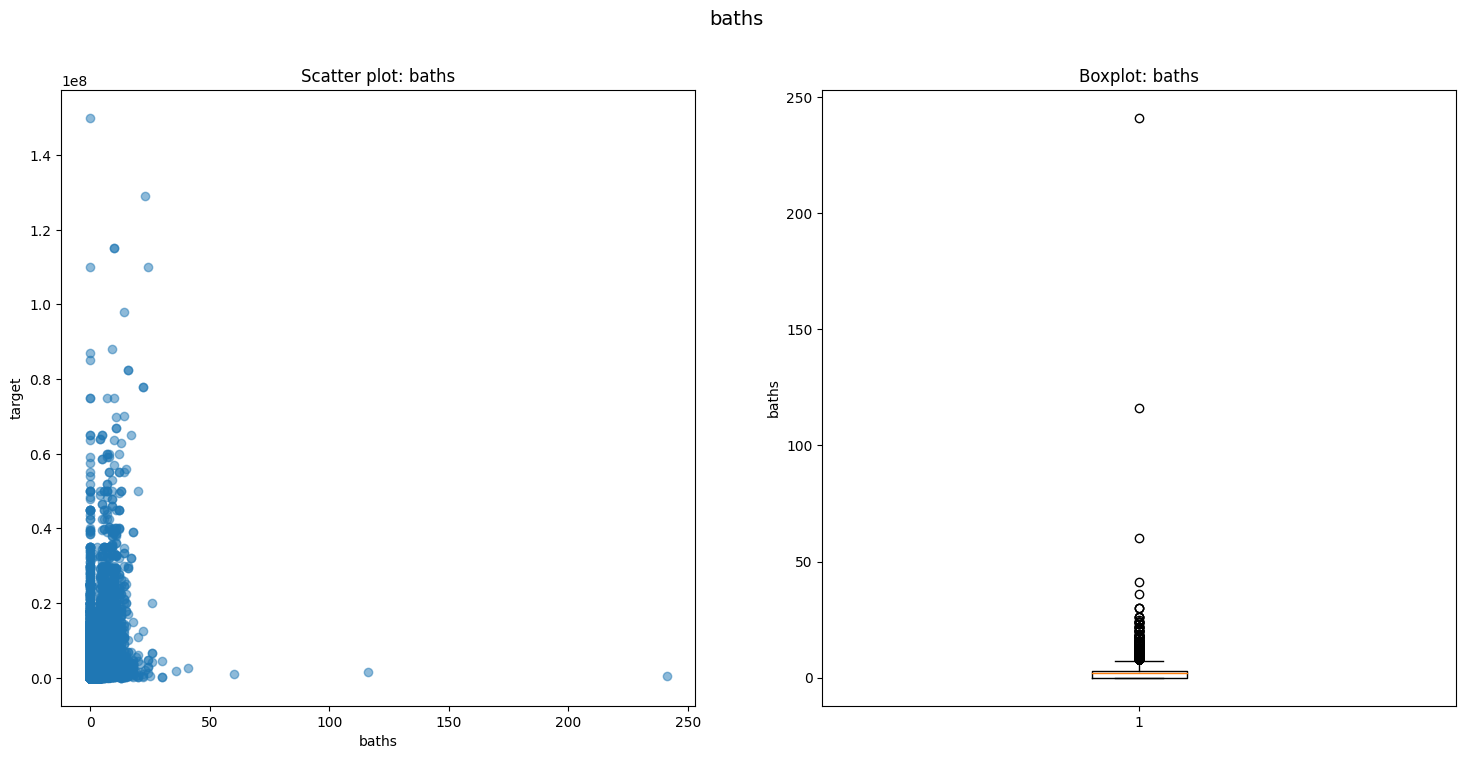

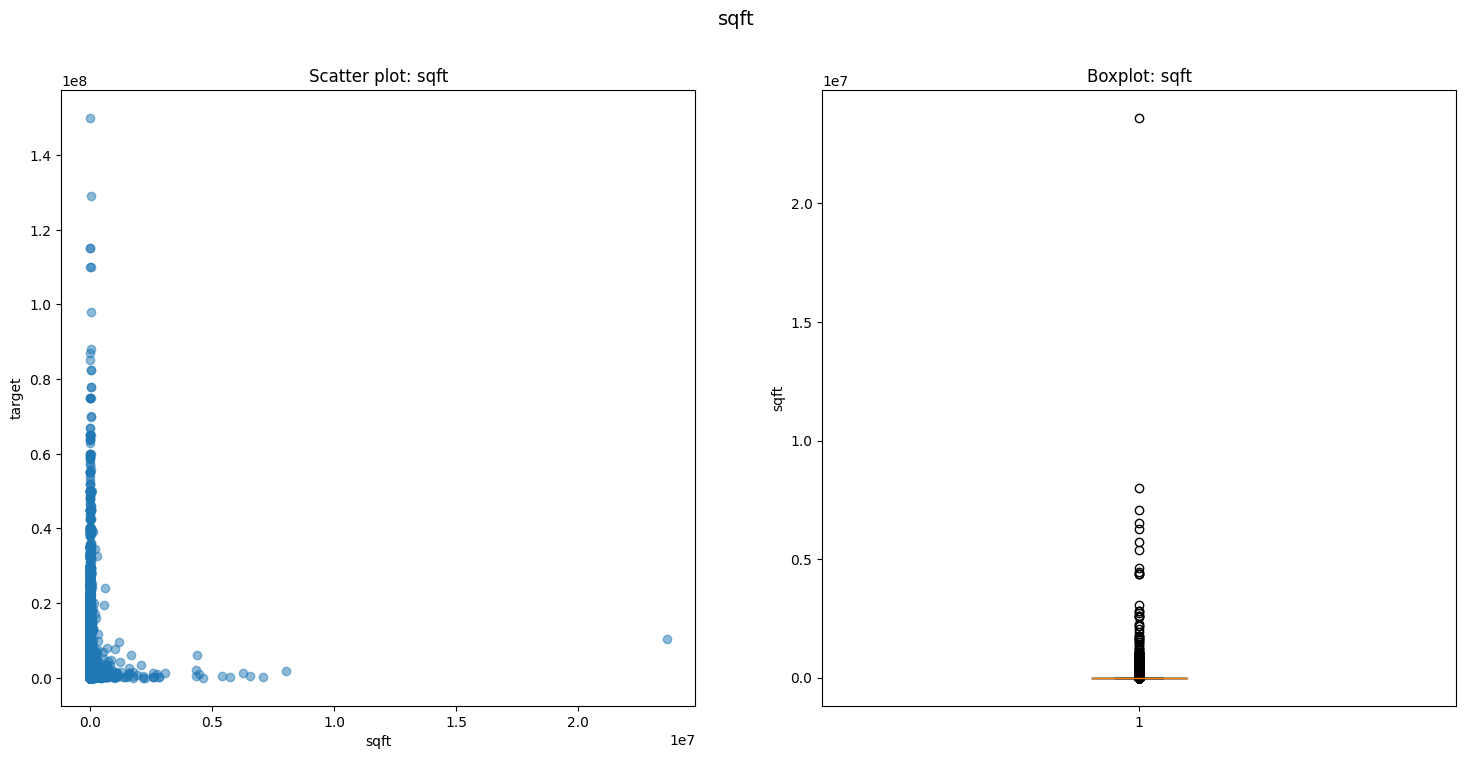

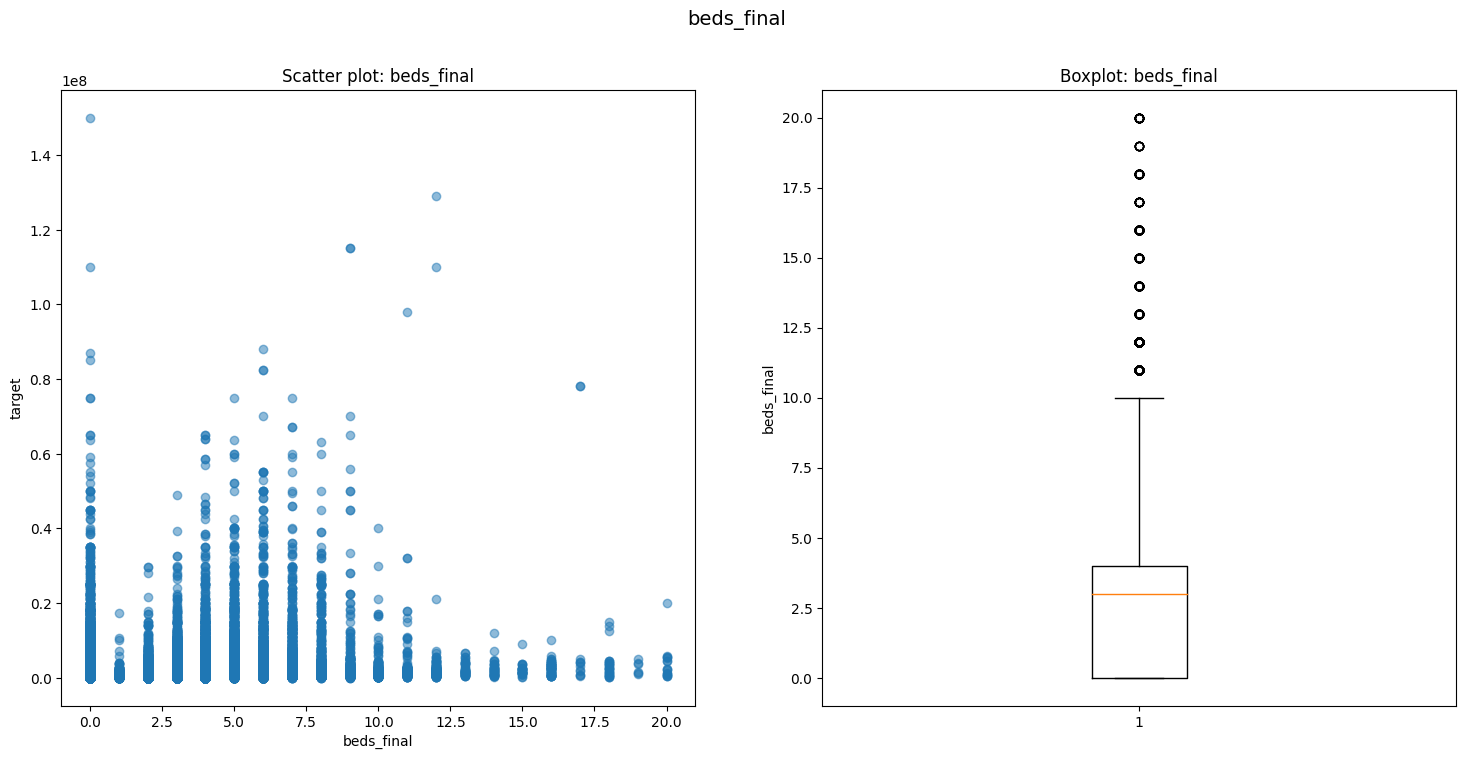

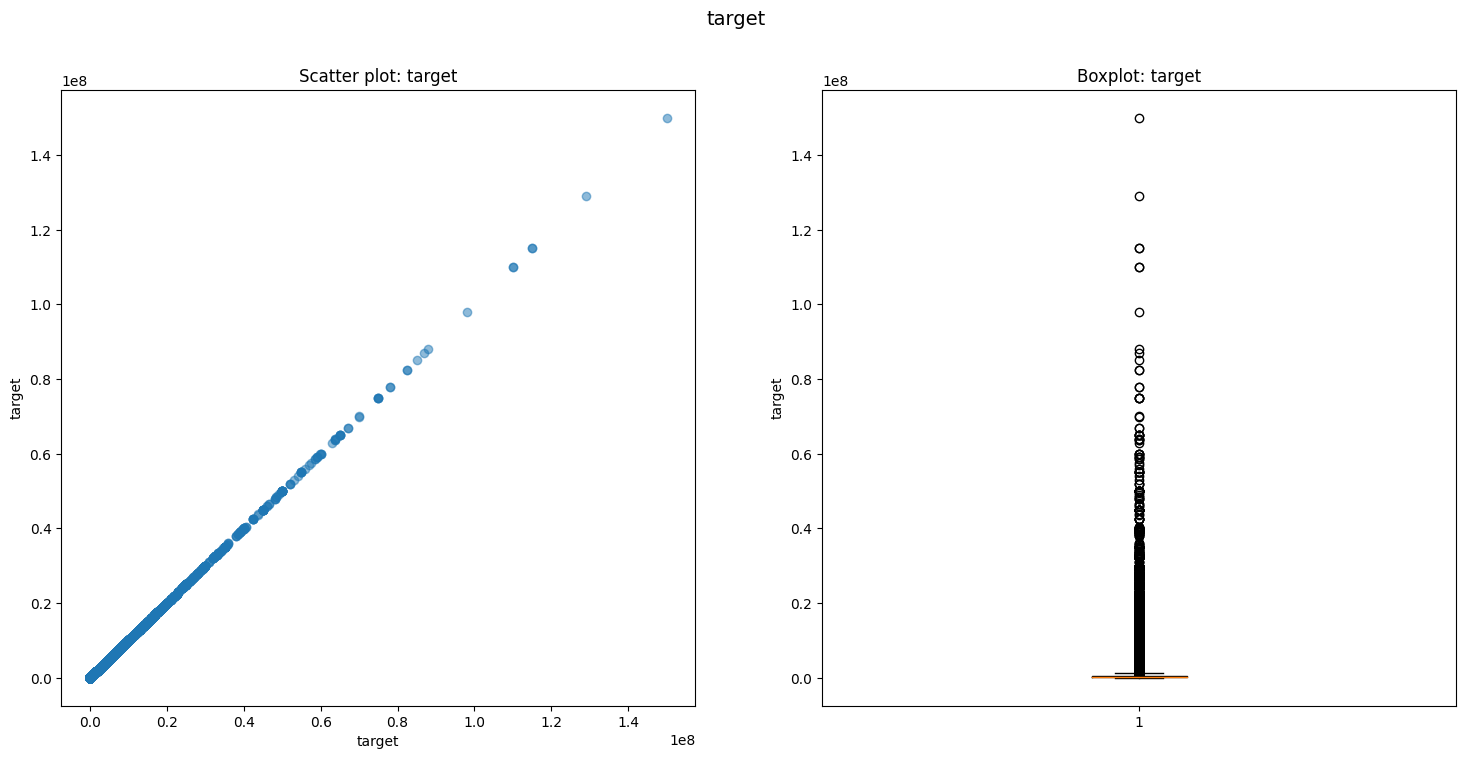

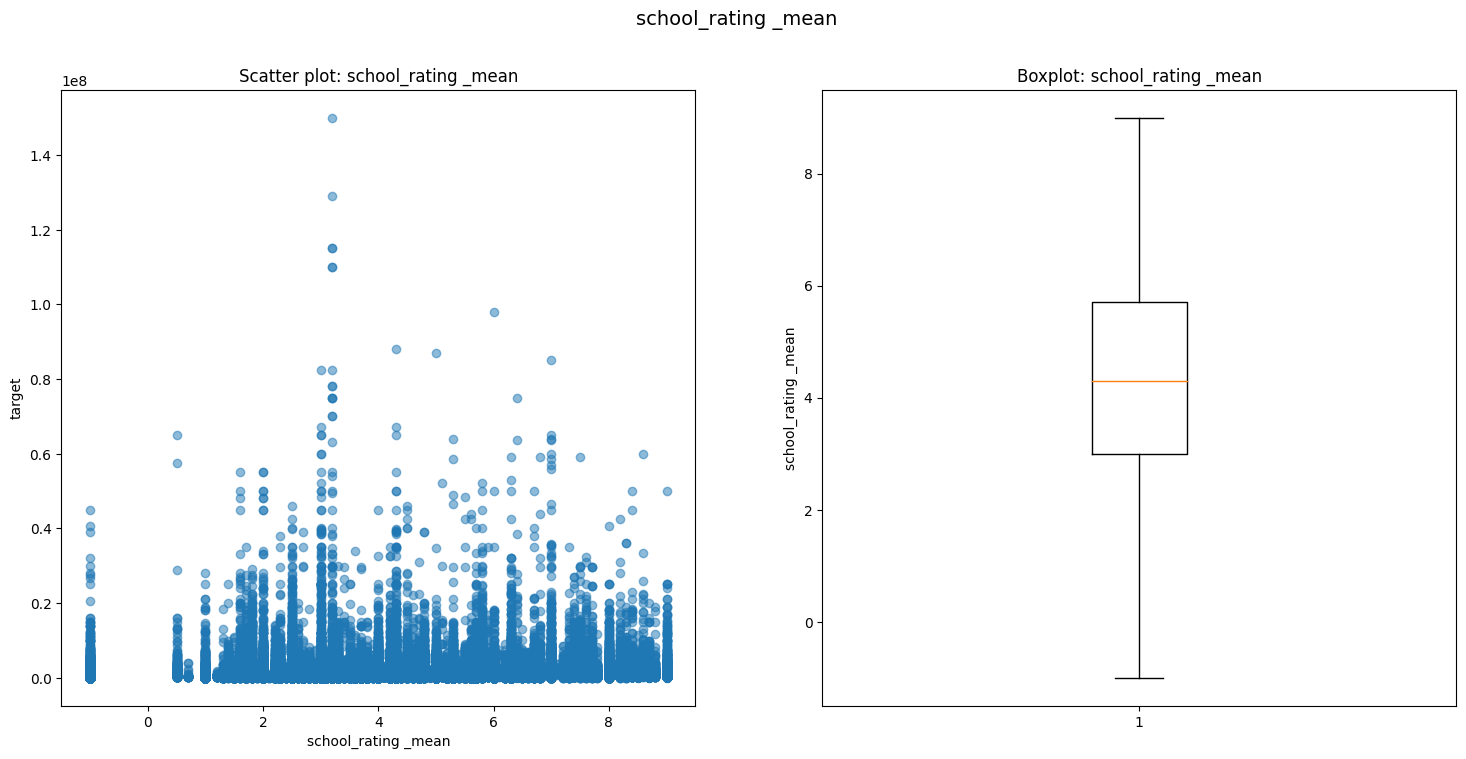

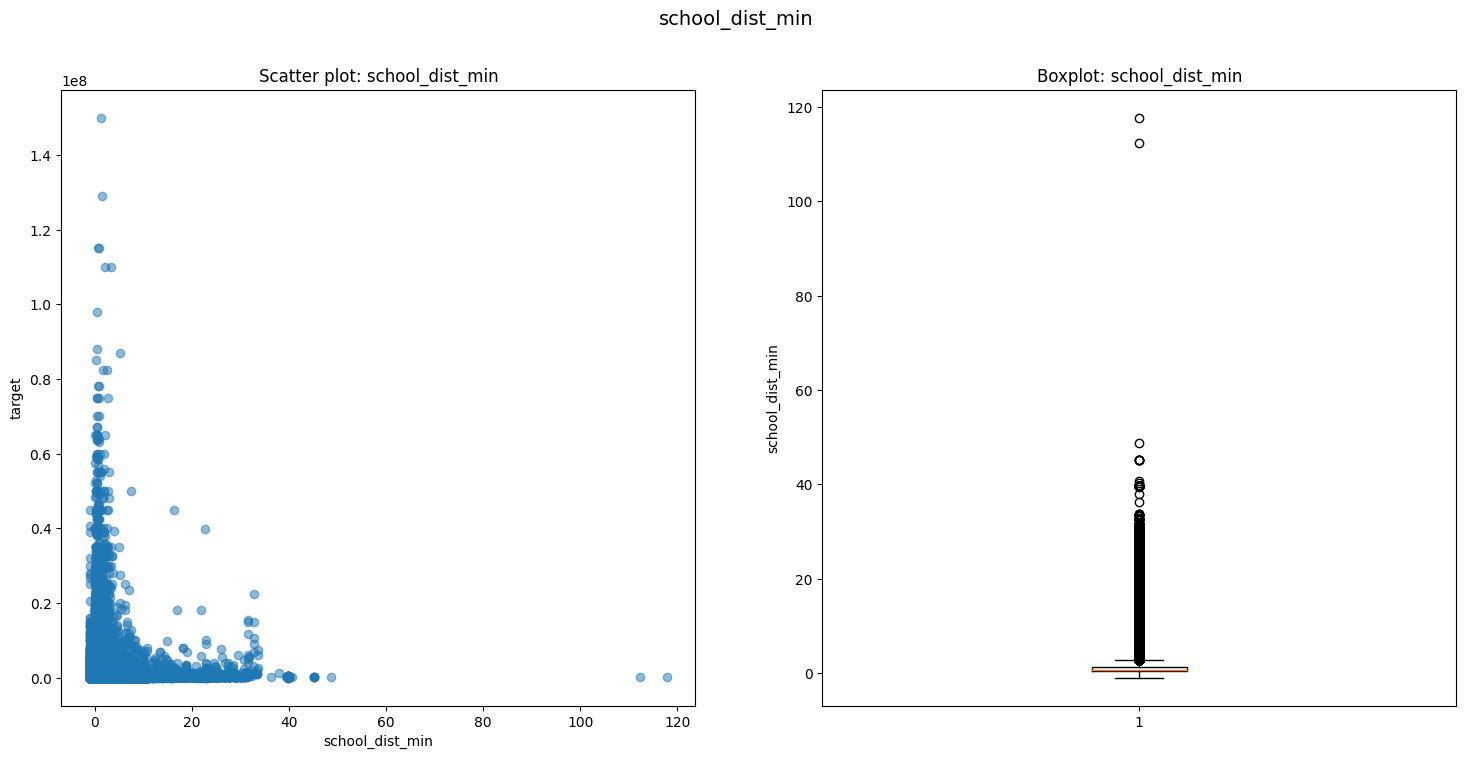

In [244]:
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle(f'{feature}', fontsize=14)

    # диаграмма рассеяния
    ax1.scatter(df[feature], df['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # коробчатая диаграмма
    ax2.boxplot(df[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

Как видим все еще остались аномальные значения, посчитаем их.

In [245]:
condition5 = ((df['baths'] > 30) | (df['target'] > 750000)) | (df['sqft'] > 200000) | (df['beds_final'] > 20) | (df['target'] > 750000)|(df['school_dist_min']> 35)
filtered5_df = df[condition5]
# выведем отфильтрованные строки
print(len(filtered5_df))
display(filtered5_df.head(7))

66230


,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool_final,beds_final,school_rating _mean,school_dist_min,Year built,Heating_final,Cooling_encoded,Parking_encoded
2,For Sale,single family,2005 Westridge Rd,2.0,Los Angeles,3000,90049,CA,2895000,True,3.0,6.7,1.19,1961,True,True,True
3,For Sale,single family,4311 Livingston Ave,8.0,Dallas,6457,75205,TX,2395000,False,5.0,5.6,0.10,2006,True,True,True
15,For Sale,other,930 52nd St,0.0,Brooklyn,0,11219,NY,1650000,False,0.0,6.3,0.20,1905,False,True,False
17,Active,townhouse,24 W 126th St,0.0,New York,3325,10027,NY,2650000,False,0.0,2.5,0.10,1899,False,False,False
21,For Sale,single family,61425 Gosney Rd,5.0,Bend,5266,97702,OR,3500000,False,5.0,6.3,3.70,2008,True,True,True
25,For Sale,single family,1755 18th St NW,7.0,Washington,5796,20009,DC,3749000,False,8.0,1.3,0.14,1915,True,True,True
26,Active,other,5755 SW 123 Ave,1.0,Miami,0,33183,FL,799000,False,0.0,3.8,0.90,unknown,False,False,False


Удалим их.

In [246]:
df.drop(df[condition5].index, inplace=True)

In [247]:
condition6 = ((df['baths'] < 1) | (df['sqft'] < 1) |(df['beds_final'] < 1))
filtered6_df = df[condition6]
# выведем отфильтрованные строки
print(len(filtered6_df))
display(filtered6_df.head(7))

110345


,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool_final,beds_final,school_rating _mean,school_dist_min,Year built,Heating_final,Cooling_encoded,Parking_encoded
4,For Sale,land,1524 Kiscoe St,0.0,Palm Bay,0,32908,FL,5000,False,0.0,4.7,3.03,unknown,False,False,False
5,For Sale,townhouse,1624 S Newkirk St,0.0,Philadelphia,897,19145,PA,209000,False,2.0,-1.0,-1.00,1920,True,True,False
6,Active,other,552 Casanova Ct,0.0,POINCIANA,1507,34759,FL,181500,False,0.0,2.3,0.80,2006,True,True,False
7,Active,other,6094 Mingle Dr,0.0,Memphis,0,38115,TN,68000,False,0.0,2.7,0.40,1976,False,False,False
11,Active,other,4222 False Cypress Ln,0.0,Houston,3130,77068,TX,260000,False,0.0,4.2,0.40,2015,True,True,False
16,Active,other,2402 NW 22nd Rd,2.0,Fort Lauderdale,2203,33311,FL,335000,False,0.0,3.5,0.50,2008,False,False,False
22,Active,other,120 Jefferson Ave #12019,1.0,Miami Beach,1080,33139,FL,579000,False,0.0,3.2,0.20,1996,True,True,False


Удаляем выбросы.

In [248]:
df.drop(df[condition6].index, inplace=True)

Снова строим диаграмму рассеяния и коробчатую диаграмму для каждого признака.

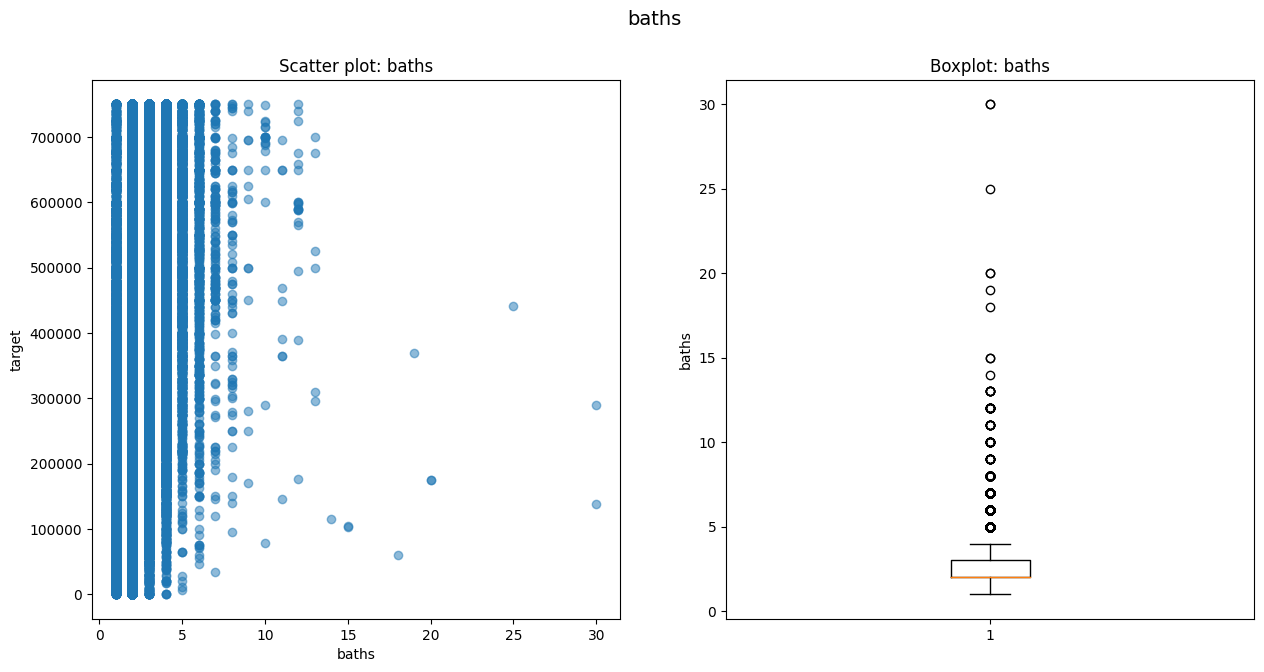

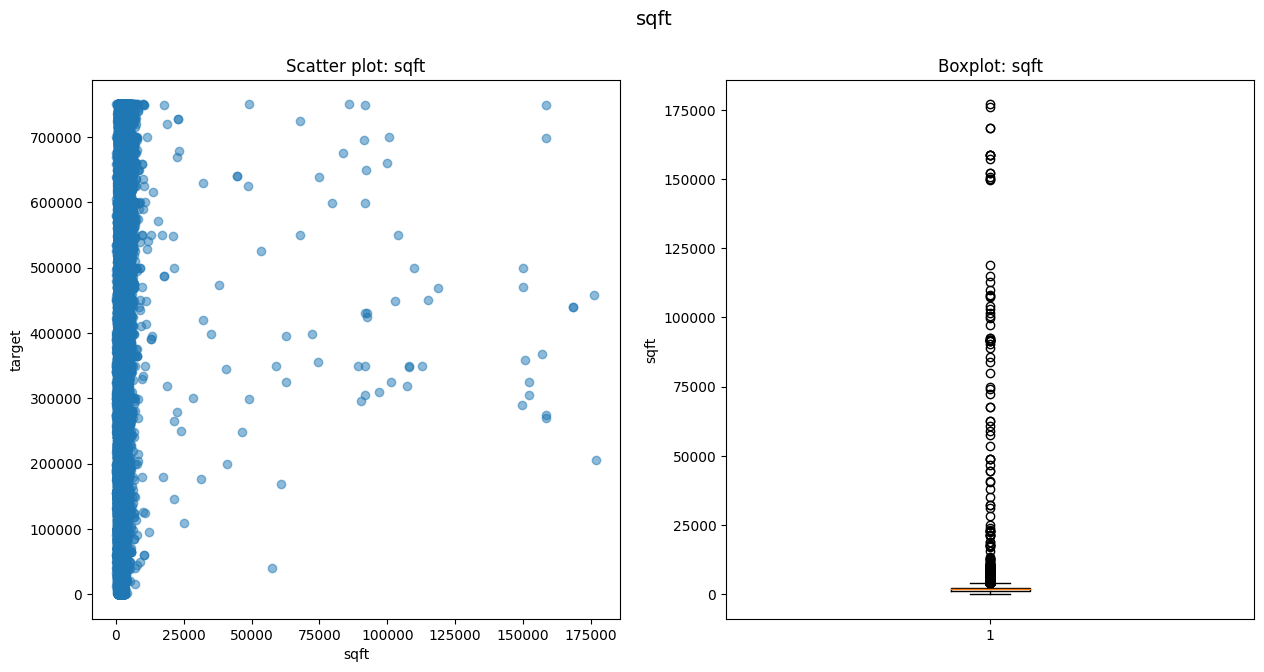

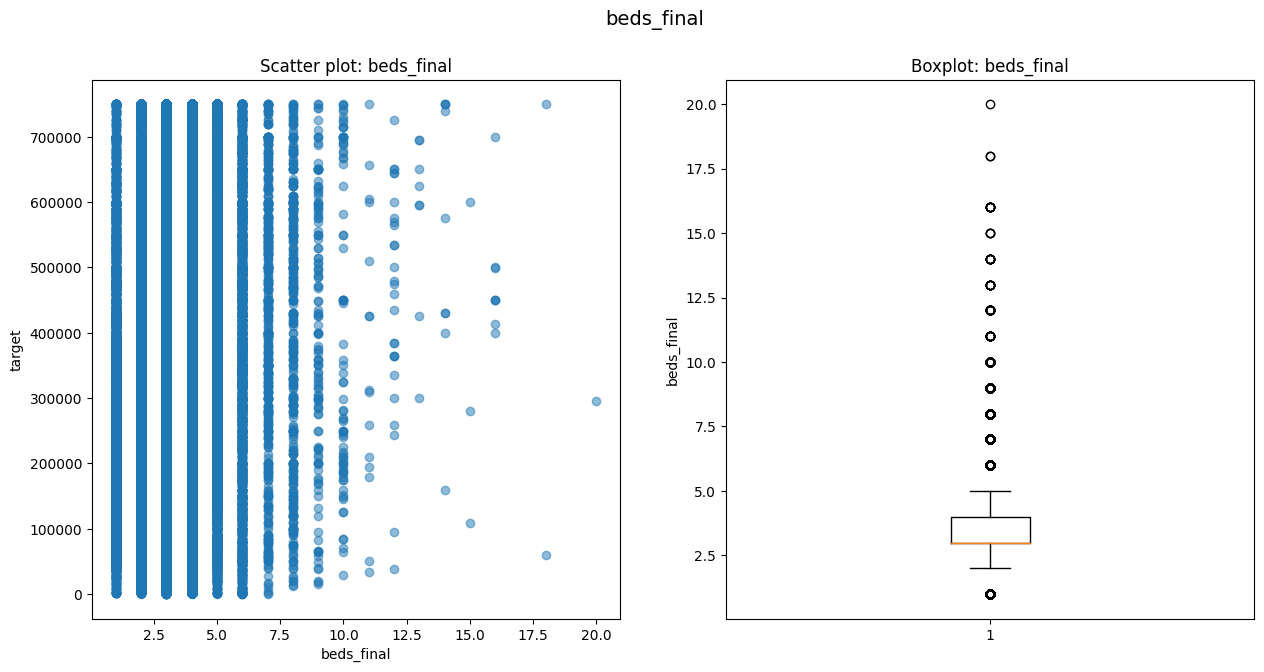

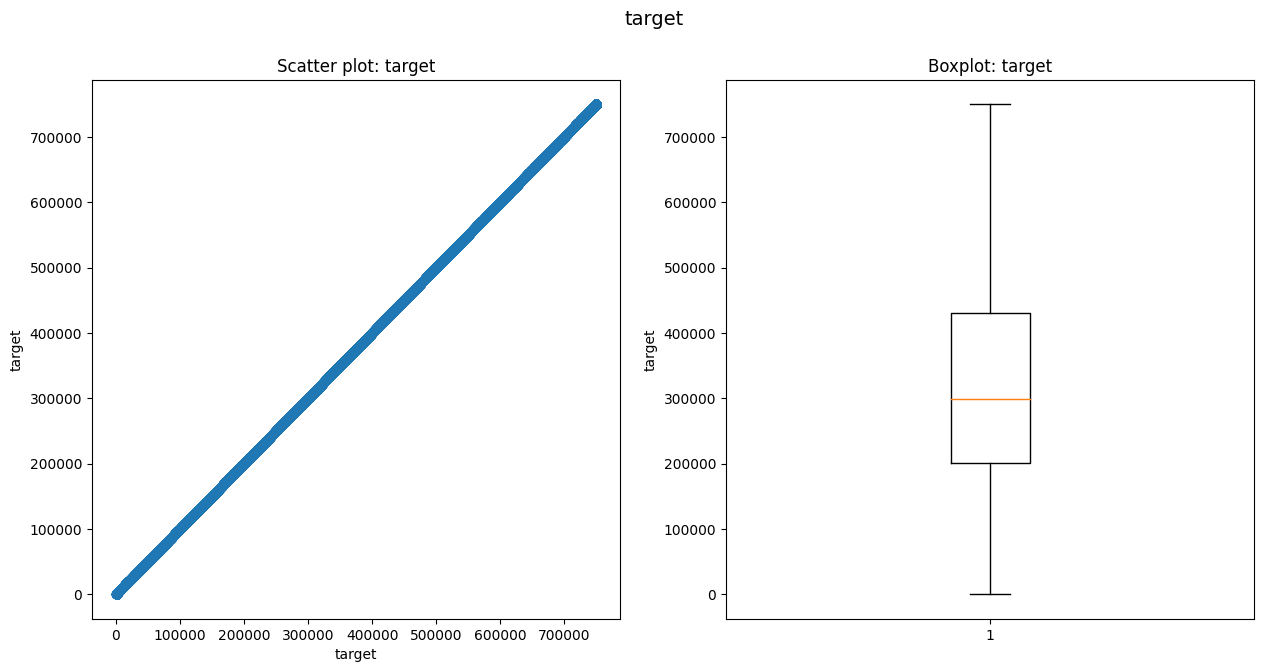

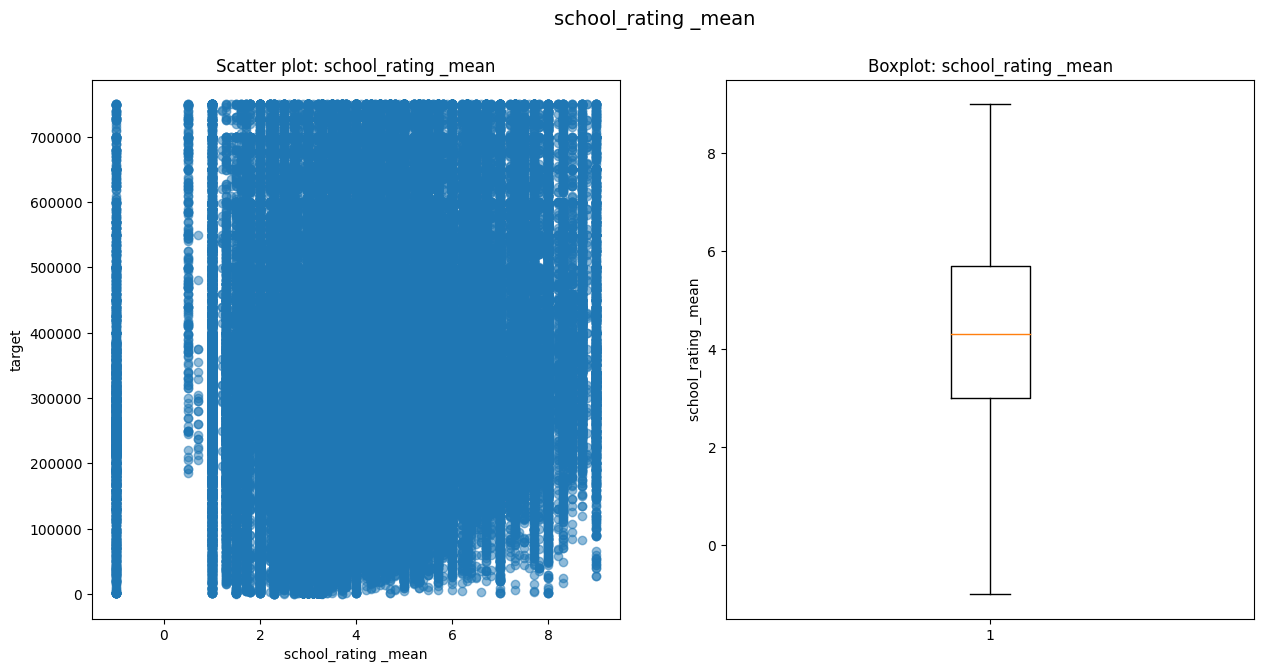

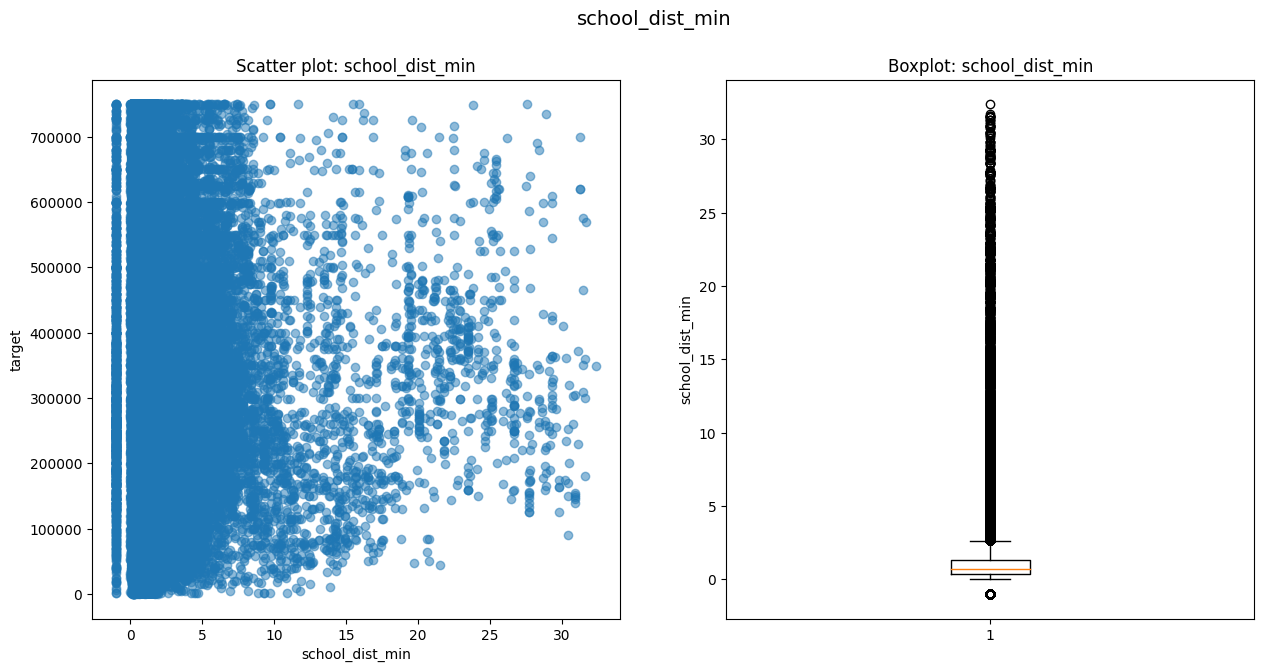

In [249]:
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle(f'{feature}', fontsize=14)

    # диаграмма рассеяния
    ax1.scatter(df[feature], df['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # коробчатая диаграмма
    ax2.boxplot(df[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

Признак street удалим из датасета.

In [250]:
df = df.drop(columns=['street'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197252 entries, 0 to 374248
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               197252 non-null  object 
 1   propertyType         197252 non-null  object 
 2   baths                197252 non-null  float64
 3   city                 197252 non-null  object 
 4   sqft                 197252 non-null  int64  
 5   zipcode              197252 non-null  object 
 6   state                197252 non-null  object 
 7   target               197252 non-null  int64  
 8   private_pool_final   197252 non-null  bool   
 9   beds_final           197252 non-null  float64
 10  school_rating _mean  197252 non-null  float64
 11  school_dist_min      197252 non-null  float64
 12  Year built           197252 non-null  object 
 13  Heating_final        197252 non-null  bool   
 14  Cooling_encoded      197252 non-null  bool   
 15  Parking_encoded  

Рассмотрим как распределились признаки.

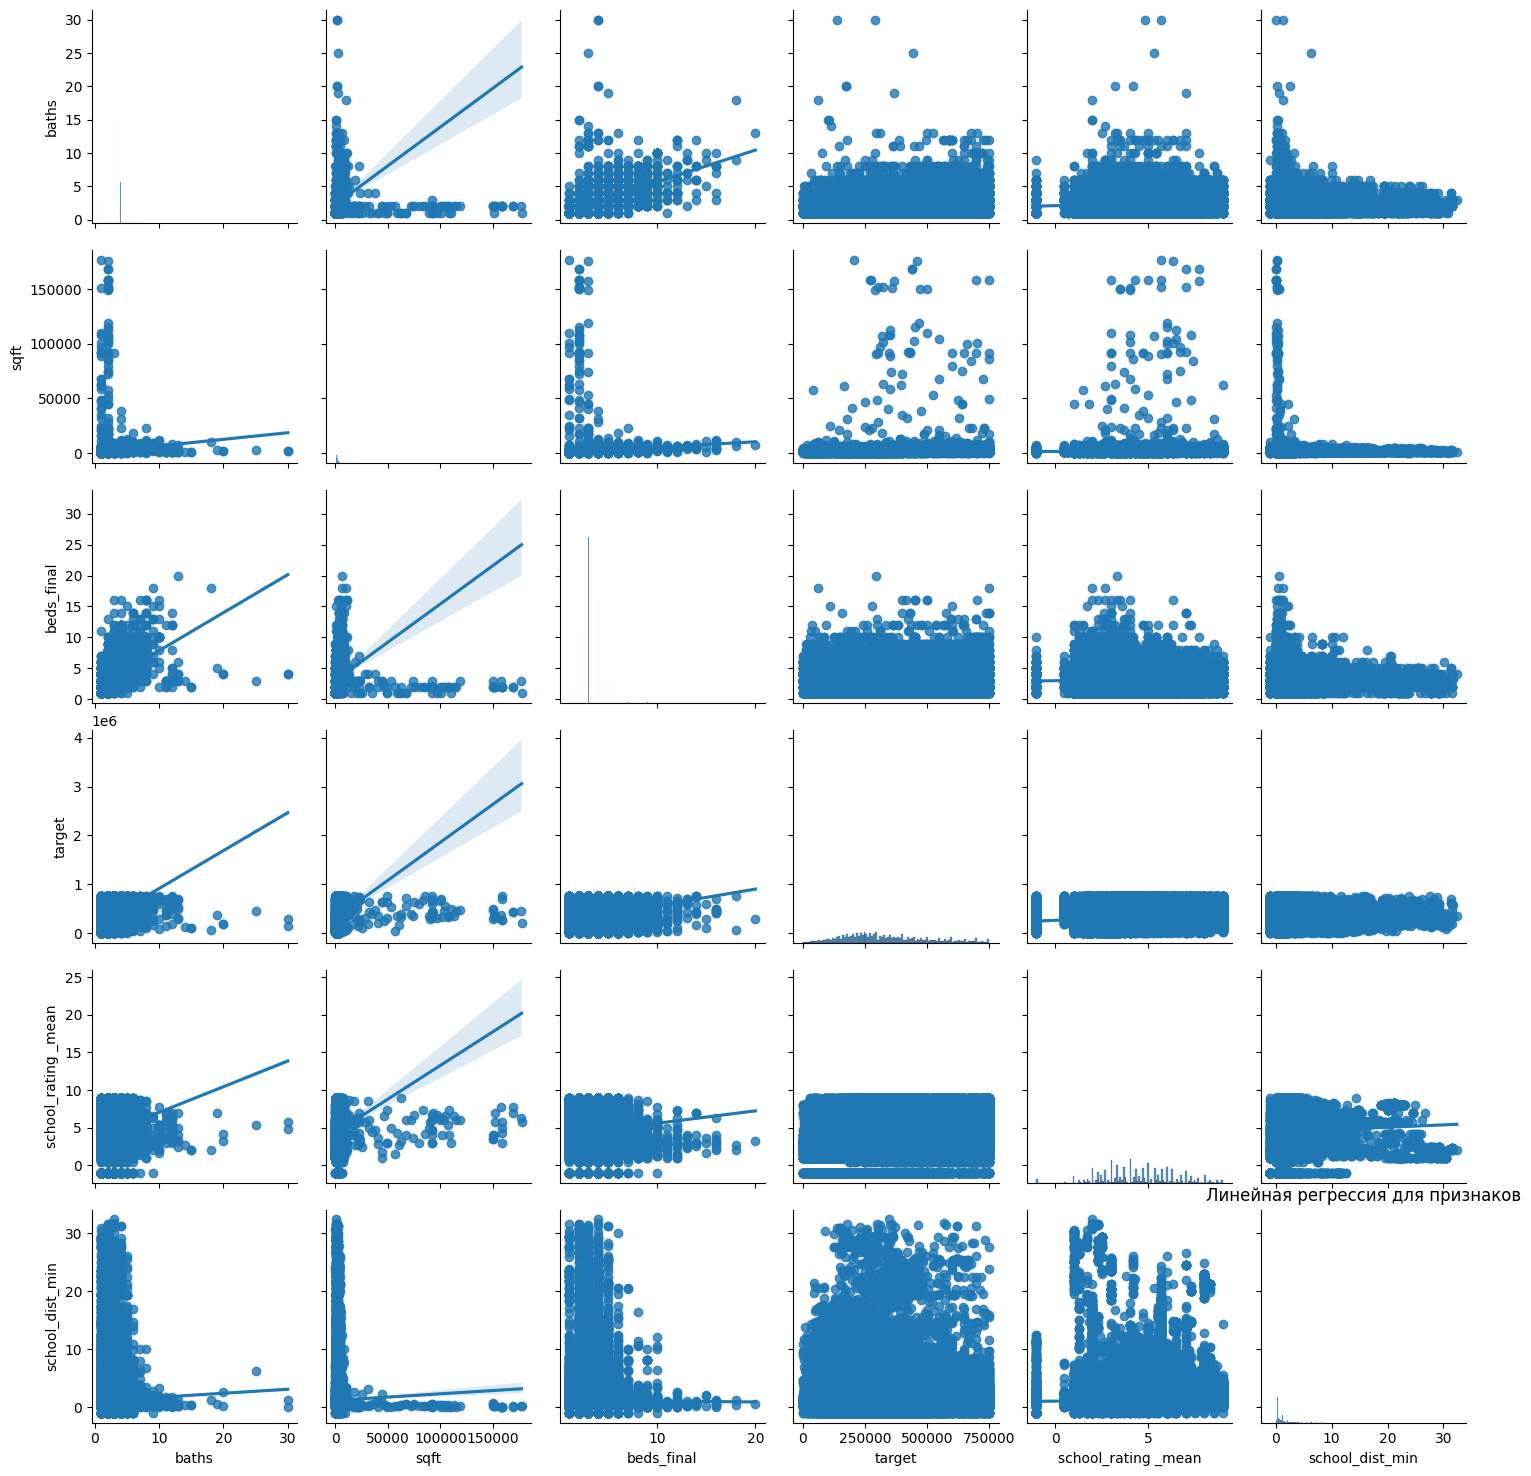

In [187]:
# выберем самые информативыне признаки из датасета
data_selected = df[num_features]
# построим линейную регрессию для этих признаков
sns.pairplot(data_selected, kind='reg')
# фикисруем заголовок
plt.title('Линейная регрессия для признаков')
# отображаем график
plt.show()

Создадим функцию для визуализации, что посмотреть распределение числовых признаков.

In [251]:
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

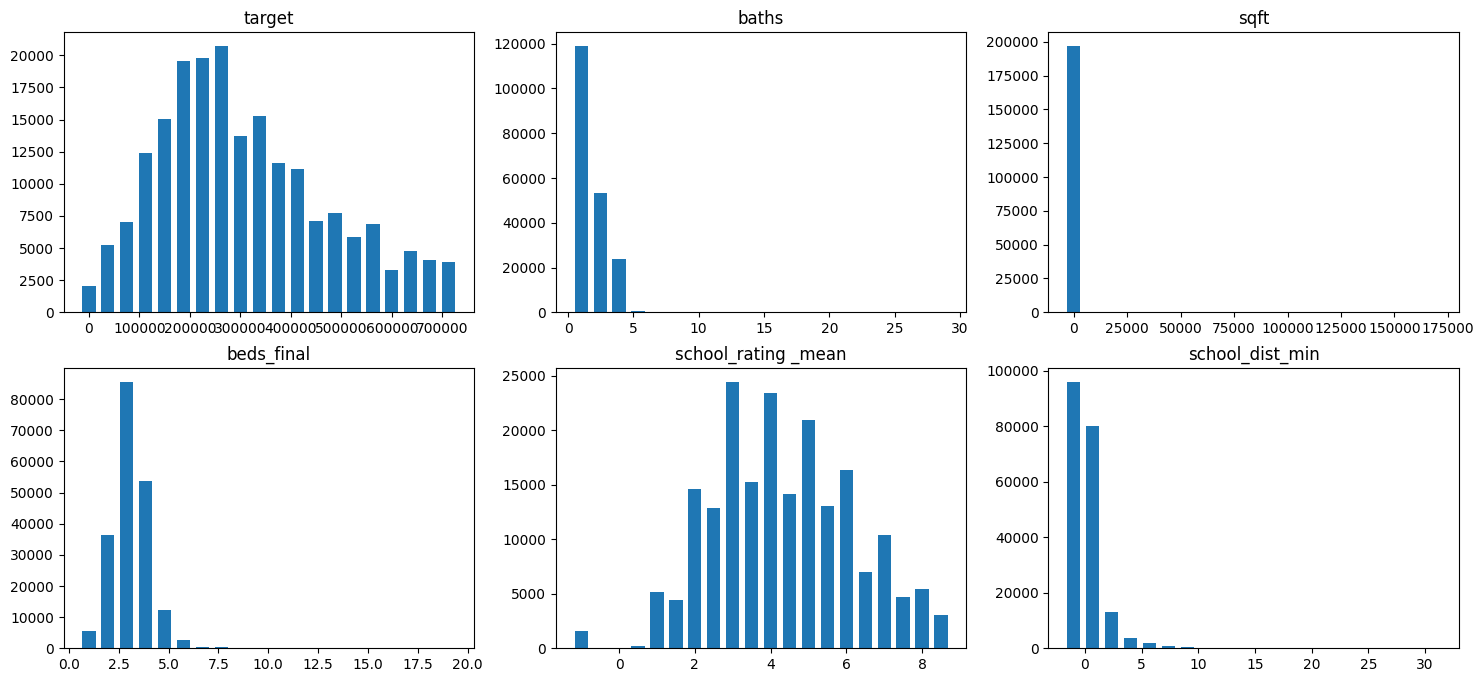

In [252]:
visualize_distributions({
    'target': df['target'],
    'baths': df['baths'],
    'sqft': df['sqft'],
    'beds_final': df['beds_final'],
    'school_rating _mean': df['school_rating _mean'],
    'school_dist_min': df['school_dist_min'],
})

Вывод: 
Исходя из графиков, для нормального распределения нужно будет их нормализовать и логорифмировать.

Проверим на мультиколлинеарность и корреляцию числовых признаков между собой и с главным признаком "target":

Ранг матрицы корреляций: 6
Определитель матрицы корреляций: 0.5059943


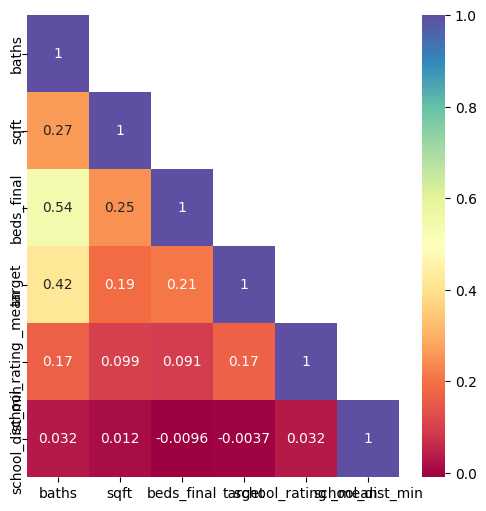

In [253]:
corr_matrix = np.corrcoef(df[num_features], rowvar=False)
print('Ранг матрицы корреляций:', np.linalg.matrix_rank(corr_matrix))
print('Определитель матрицы корреляций: {:.7f}'.format(np.linalg.det(corr_matrix)))

# формируем нижний угол матрицы корреляций
corr_matrix_tril = np.tril(corr_matrix)
# заполняем верхний угол значениями NaN
corr_matrix_tril[corr_matrix_tril == 0] = np.nan

# создаем фигуру с автоматическим масштабированием
plt.figure(figsize=(len(df[num_features].columns), len(df[num_features].columns)))

# строим тепловую карту
sns.heatmap(corr_matrix_tril, annot=True, cmap='Spectral', mask=np.isnan(corr_matrix_tril))
# добавляем подписи столбцов на тепловой карте
plt.xticks(np.arange(len(df[num_features].columns))+0.5, df[num_features].columns, rotation=0, ha='center', fontsize=10)
plt.yticks(np.arange(len(df[num_features].columns))+0.5, df[num_features].columns, ha='center', fontsize=10, va='center', rotation=90)
# отображаем график
plt.show()

Можем увидеть сильную коррелияцию у двух признаков baths и beds_final. Удалим beds_final, тк количество ванных комнат информативнее, тк недвижимость в целом оценивается по площади, а не по количеству спален.

In [254]:
df = df.drop('beds_final', axis=1)

**Анализ категориальных признаков.**

Создадим список категориальных признаков.

In [255]:
cat_features = ['status', 'propertyType', 'zipcode', 'state', 'city', 'Year built']
df.describe(include = 'object')

,status,propertyType,city,zipcode,state,Year built
count,197252,197252,197252,197252,197252,197252
unique,11,10,1535,3925,34,206
top,For Sale,single family,Houston,78245,FL,2019
freq,125848,142810,12450,1109,58652,19994


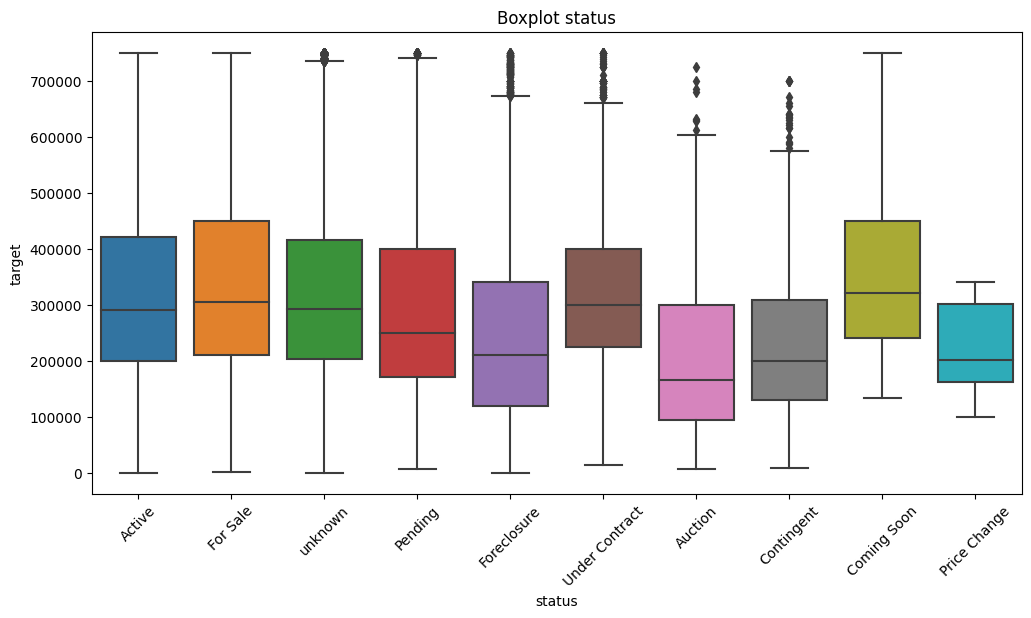

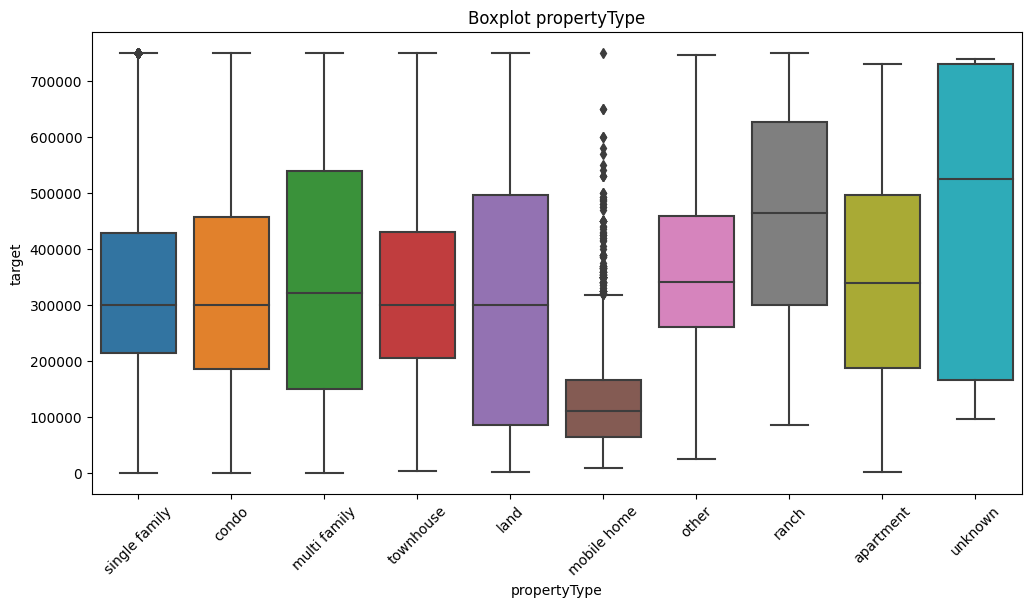

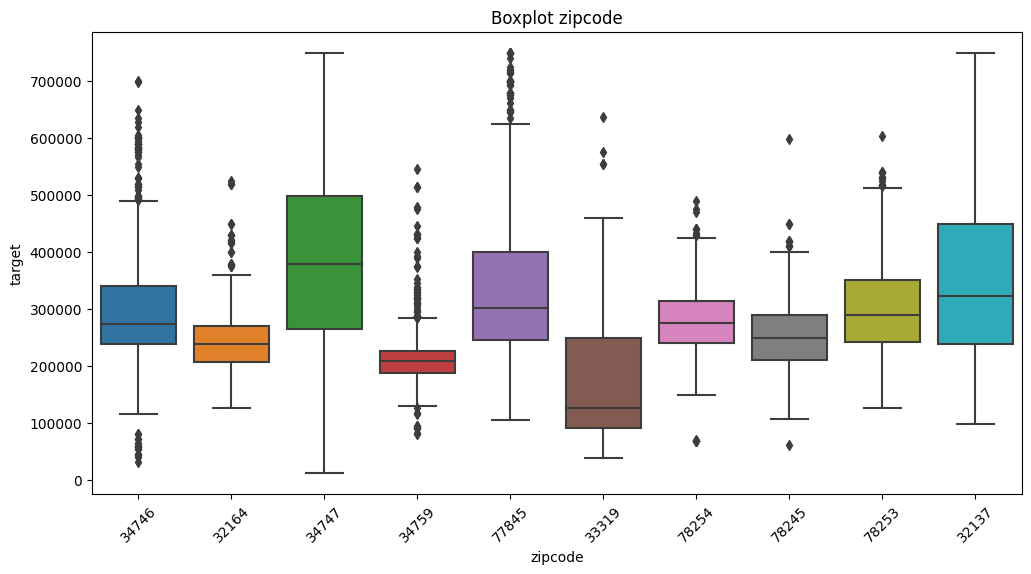

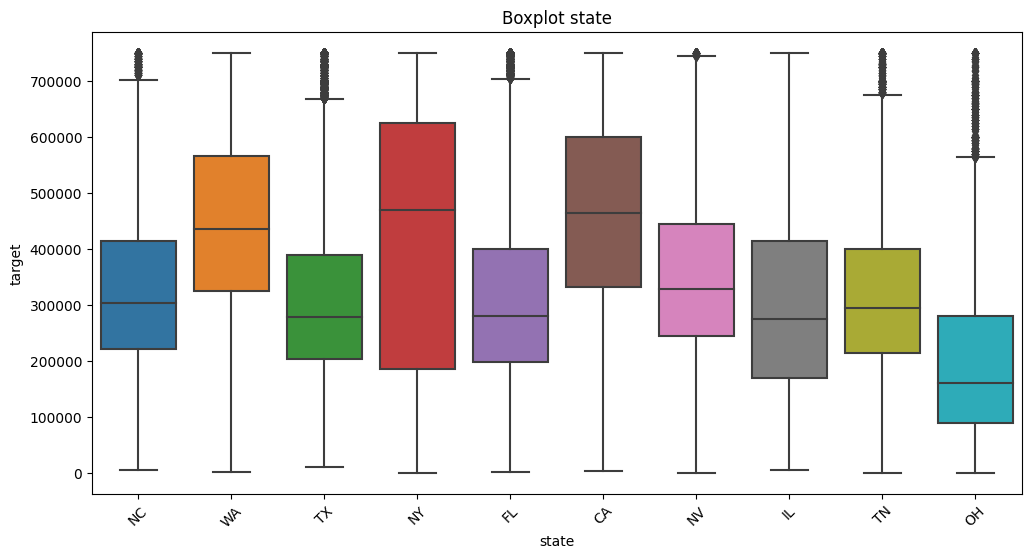

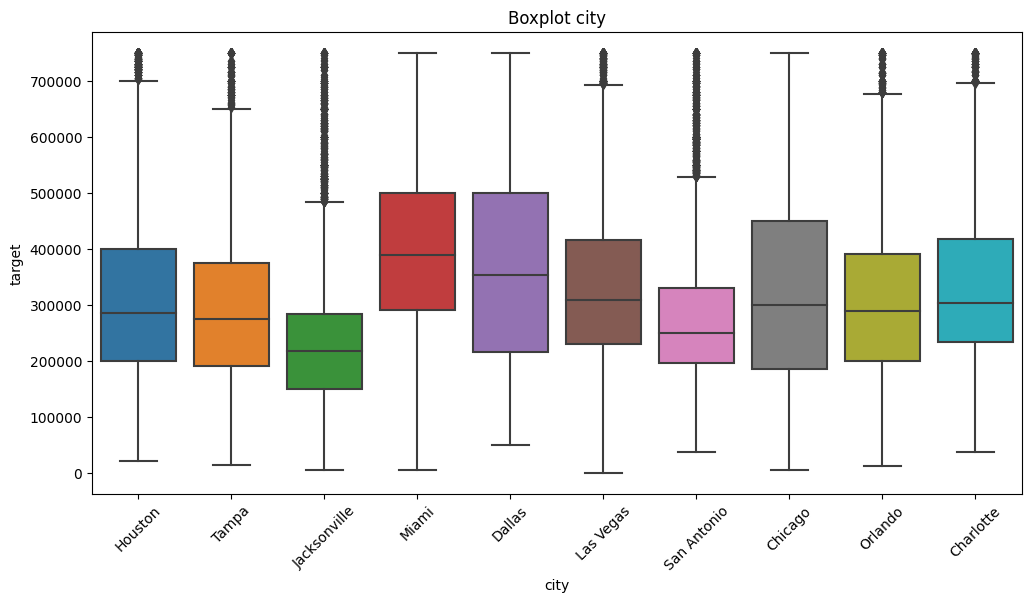

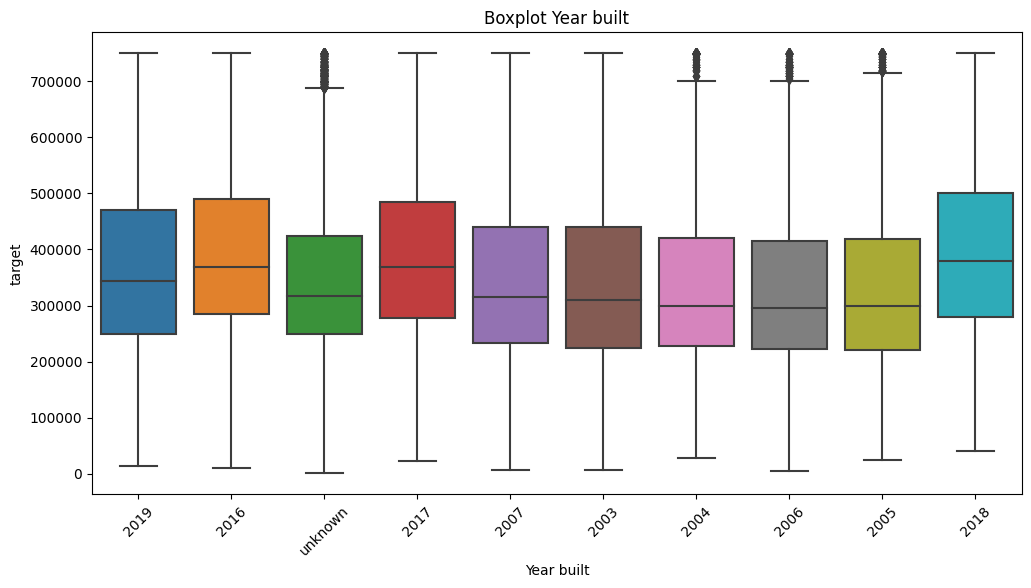

In [256]:
cat_features = ['status', 'propertyType', 'zipcode', 'state', 'city', 'Year built']
for cat in cat_features:
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.boxplot(x=cat, y='target', data=df.loc[df.loc[:, cat].isin(df.loc[:, cat].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot ' + cat)
    plt.show()

Так как у нас признаки разпределены ненормально, но сделана предварительноя очистка данных и удаление выбросов, то будем использовать MinMaxScaler нормализацию для числовых признаков.

In [257]:
# создаем объект MinMaxScaler
scaler = MinMaxScaler()

# отбираем столбцы для нормализации
col_names = ['sqft', 'baths', 'school_rating _mean', 'school_dist_min', 'target']

# нормализируем и преобразовываем данные обратно в DataFrame
df[col_names] = scaler.fit_transform(df[col_names])

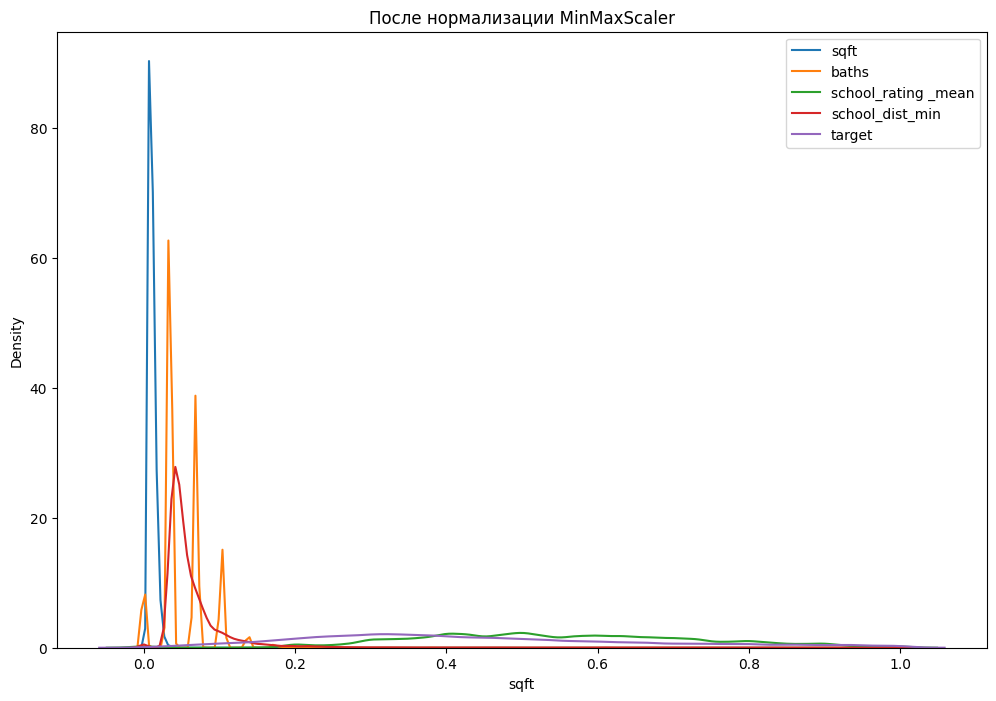

In [258]:
# посмотрим по графикам как изменилось распределение признаков после нормализации
fig, (ax1) = plt.subplots(ncols=1, figsize=(12, 8))
ax1.set_title('После нормализации MinMaxScaler')

sns.kdeplot(df['sqft'], ax=ax1, label='sqft')
sns.kdeplot(df['baths'], ax=ax1, label='baths')
sns.kdeplot(df['school_rating _mean'], ax=ax1, label='school_rating _mean')
sns.kdeplot(df['school_dist_min'], ax=ax1, label='school_dist_min')
sns.kdeplot(df['target'], ax=ax1, label='target')
ax1.legend()

In [259]:
# логорифмирование данных
for col in col_names:
        df[col] = df[col].apply(lambda x: abs(x))
        constant = 1e-6
        df[col] = np.log(df[col] + constant)
df


,status,propertyType,baths,city,sqft,zipcode,state,target,private_pool_final,school_rating _mean,school_dist_min,Year built,Heating_final,Cooling_encoded,Parking_encoded
0,Active,single family,-2.268674,Southern Pines,-4.111717,28387,NC,-0.584591,False,-0.478034,-2.200214,2019,True,False,False
1,For Sale,single family,-2.674134,Spokane Valley,-4.510277,99216,WA,-0.883500,False,-0.693145,-2.810405,2019,False,False,False
8,Active,single family,-3.367267,Mason City,-3.898779,50401,IA,-1.119223,False,-0.733967,-1.621481,1970,True,True,False
9,unknown,single family,-2.674134,Houston,-4.519051,77080,TX,-0.877086,False,-0.916288,-3.038531,2019,True,True,True
10,For Sale,condo,-3.367267,Flushing,-4.914413,11354,NY,-0.114288,False,-0.967581,-3.246166,1965,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374240,unknown,single family,-3.367267,Orlando,-4.572825,32805,FL,-1.476622,False,-1.108660,-2.766603,1962,True,True,True
374242,unknown,single family,-3.367267,Houston,-4.566282,77089,TX,-1.086723,False,-0.356674,-3.246166,2019,False,True,True
374245,For Sale,condo,-2.674134,Chicago,-4.483408,60657,IL,-0.105361,False,-0.634876,-3.172060,1924,True,False,False
374246,For Sale,single family,-2.674134,Jamaica,-5.035359,11434,NY,-0.350976,False,-0.597835,-3.116491,1950,True,False,True


Посмотрим по графикам как изменилось распределение признаков после логарифмирования.

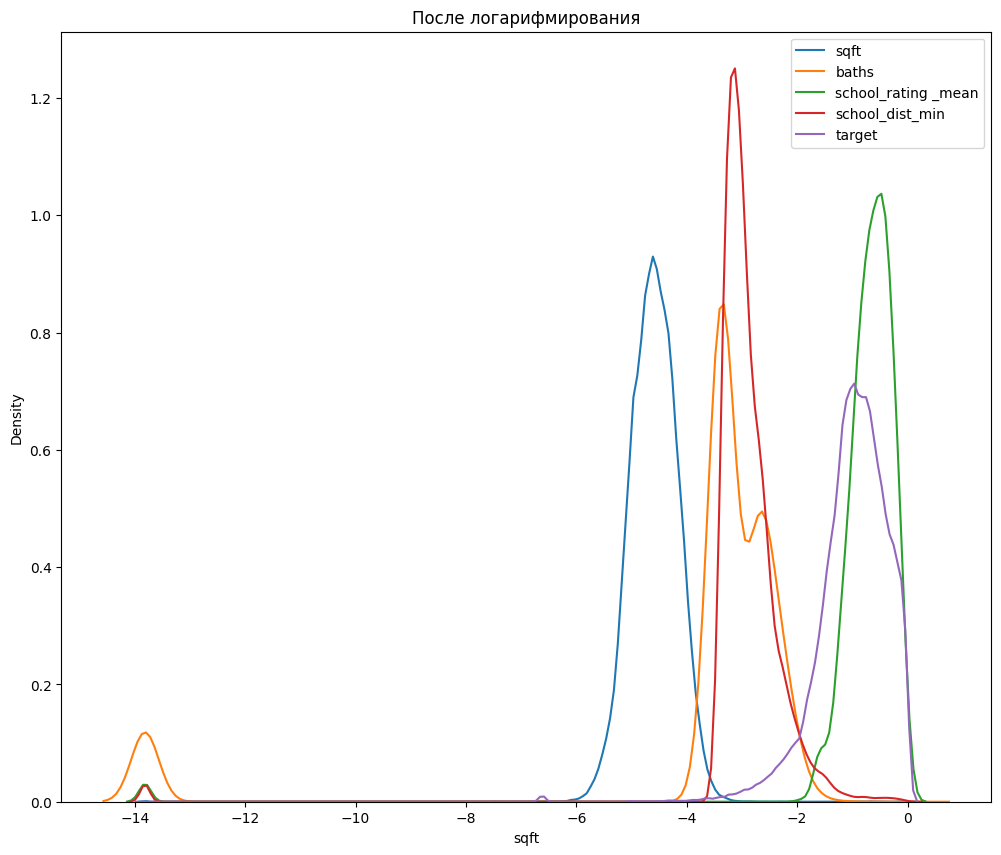

In [260]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(12, 10))
ax1.set_title('После логарифмирования')

sns.kdeplot(df['sqft'], ax=ax1, label='sqft')
sns.kdeplot(df['baths'], ax=ax1, label='baths')
sns.kdeplot(df['school_rating _mean'], ax=ax1, label='school_rating _mean')
sns.kdeplot(df['school_dist_min'], ax=ax1, label='school_dist_min')
sns.kdeplot(df['target'], ax=ax1, label='target')
ax1.legend()

После нормализации мы видим нормальное распределение признаков, хоть и несимметричное, а вот после логарифмирования данных распределение сильно поменялось.

Сохраним данные в CSV-файл для работы в CatBoost без кодировки категориальных признаков.


In [261]:
df.to_csv("data/cleaned_data_for_CatBoost.csv", index=False)

Прочитаем файл с данными для дальнейшего кодирования.

In [262]:
df = pd.read_csv('data/cleaned_data_for_CatBoost.csv')
df.head()

,status,propertyType,baths,city,sqft,zipcode,state,target,private_pool_final,school_rating _mean,school_dist_min,Year built,Heating_final,Cooling_encoded,Parking_encoded
0,Active,single family,-2.268674,Southern Pines,-4.111717,28387,NC,-0.584591,False,-0.478034,-2.200214,2019,True,False,False
1,For Sale,single family,-2.674134,Spokane Valley,-4.510277,99216,WA,-0.883500,False,-0.693145,-2.810405,2019,False,False,False
2,Active,single family,-3.367267,Mason City,-3.898779,50401,IA,-1.119223,False,-0.733967,-1.621481,1970,True,True,False
3,unknown,single family,-2.674134,Houston,-4.519051,77080,TX,-0.877086,False,-0.916288,-3.038531,2019,True,True,True
4,For Sale,condo,-3.367267,Flushing,-4.914413,11354,NY,-0.114288,False,-0.967581,-3.246166,1965,False,False,True


In [263]:
df.describe(include = 'object')

,status,propertyType,city,state,Year built
count,197252,197252,197252,197252,197252
unique,11,10,1535,34,206
top,For Sale,single family,Houston,FL,2019
freq,125848,142810,12450,58652,19994


Кодируем признаки:
- однократное кодирование OneHotEncoder: status, propertyType
- другие кодируем LabelEncoder (city, state, Year built)

In [264]:
df_encoded = pd.get_dummies(df, columns=['status', 'propertyType'])
df_encoded.head()

,baths,city,sqft,zipcode,state,target,private_pool_final,school_rating _mean,school_dist_min,Year built,...,propertyType_apartment,propertyType_condo,propertyType_land,propertyType_mobile home,propertyType_multi family,propertyType_other,propertyType_ranch,propertyType_single family,propertyType_townhouse,propertyType_unknown
0,-2.268674,Southern Pines,-4.111717,28387,NC,-0.584591,False,-0.478034,-2.200214,2019,...,0,0,0,0,0,0,0,1,0,0
1,-2.674134,Spokane Valley,-4.510277,99216,WA,-0.883500,False,-0.693145,-2.810405,2019,...,0,0,0,0,0,0,0,1,0,0
2,-3.367267,Mason City,-3.898779,50401,IA,-1.119223,False,-0.733967,-1.621481,1970,...,0,0,0,0,0,0,0,1,0,0
3,-2.674134,Houston,-4.519051,77080,TX,-0.877086,False,-0.916288,-3.038531,2019,...,0,0,0,0,0,0,0,1,0,0
4,-3.367267,Flushing,-4.914413,11354,NY,-0.114288,False,-0.967581,-3.246166,1965,...,0,1,0,0,0,0,0,0,0,0


In [265]:
# кодируем оставшиеся признаки
state_le = LabelEncoder()
state_label = state_le.fit_transform(df_encoded['state'])

yearb_le = LabelEncoder()
yearb_label = yearb_le.fit_transform(df_encoded['Year built'])

city_le = LabelEncoder()
city_label = city_le.fit_transform(df_encoded['city'])

# добавляем закодированные столбцы в дата фрейм
df_encoded['state_label'] = state_label
df_encoded['year_label'] = yearb_label
df_encoded['city_label'] = city_label

# удаляем обработанные столбцы
df_encoded.drop(['state', 'city','Year built'], axis=1, inplace=True)

In [266]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197252 entries, 0 to 197251
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   baths                       197252 non-null  float64
 1   sqft                        197252 non-null  float64
 2   zipcode                     197252 non-null  int64  
 3   target                      197252 non-null  float64
 4   private_pool_final          197252 non-null  bool   
 5   school_rating _mean         197252 non-null  float64
 6   school_dist_min             197252 non-null  float64
 7   Heating_final               197252 non-null  bool   
 8   Cooling_encoded             197252 non-null  bool   
 9   Parking_encoded             197252 non-null  bool   
 10  status_Active               197252 non-null  uint8  
 11  status_Auction              197252 non-null  uint8  
 12  status_Coming Soon          197252 non-null  uint8  
 13  status_Conting

Сохраним датасет для дальнейшего использования при обучении модели.

In [267]:
# сохраняем пданные в CSV-файл для упрощения дальнейшей работы
df_encoded.to_csv("data/cleaned_data_model.csv", index=False)